# Importing Libraries

In [848]:

import numpy as np
import pandas as pd
from pathlib import Path
import missingno as msno

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ydata_profiling import ProfileReport
import os
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.ticker
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency

from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE


# Loading Data

In [849]:
cc_data_full_data = pd.read_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/application_record.csv')
credit_status = pd.read_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/credit_record.csv')

In [850]:
cc_data_full_data

ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0       5008804           M            Y               Y             0   
1       5008805           M            Y               Y             0   
2       5008806           M            Y               Y             0   
3       5008808           F            N               Y             0   
4       5008809           F            N               Y             0   
...         ...         ...          ...             ...           ...   
438552  6840104           M            N               Y             0   
438553  6840222           F            N               N             0   
438554  6841878           F            N               N             0   
438555  6842765           F            N               Y             0   
438556  6842885           F            N               Y             0   

        AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0              427500.00               Working               Higher education   
1              427500.00               Working               Higher education   
2              112500.00               Working  Secondary / secondary special   
3              270000.00  Commercial associate  Secondary / secondary special   
4              270000.00  Commercial associate  Secondary / secondary special   
...                  ...                   ...                            ...   
438552         135000.00             Pensioner  Secondary / secondary special   
438553         103500.00               Working  Secondary / secondary special   
438554          54000.00  Commercial associate               Higher education   
438555          72000.00             Pensioner  Secondary / secondary special   
438556         121500.00               Working  Secondary / secondary special   

          NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0             Civil marriage   Rented apartment      -12005          -4542   
1             Civil marriage   Rented apartment      -12005          -4542   
2                    Married  House / apartment      -21474          -1134   
3       Single / not married  House / apartment      -19110          -3051   
4       Single / not married  House / apartment      -19110          -3051   
...                      ...                ...         ...            ...   
438552             Separated  House / apartment      -22717         365243   
438553  Single / not married  House / apartment      -15939          -3007   
438554  Single / not married       With parents       -8169           -372   
438555               Married  House / apartment      -21673         365243   
438556               Married  House / apartment      -18858          -1201   

        FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0                1                1           0           0             NaN   
1                1                1           0           0             NaN   
2                1                0           0           0  Security staff   
3                1                0           1           1     Sales staff   
4                1                0           1           1     Sales staff   
...            ...              ...         ...         ...             ...   
438552           1                0           0           0             NaN   
438553           1                0           0           0        Laborers   
438554           1                1           0           0     Sales staff   
438555           1                0           0           0             NaN   
438556           1                0           1           0     Sales staff   

        CNT_FAM_MEMBERS  
0                  2.00  
1                  2.00  
2                  2.00  
3                  1.00  
4                  1.00  
...                 ...  
438552             1.00  
438553             1.00  
438554             1.00  
43855

In [851]:
cc_data_full_data['ID'].nunique()

438510

In [852]:
credit_status

ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]

In [853]:
credit_status['ID'].nunique()

45985

STATUS
- C: paid off that month 
- X: No loan for the month
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 

In [854]:
credit_status['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

Creating target variable

In [855]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')

This creates a value to guage how risky is that client

In [856]:
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]

In [857]:
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning SettingWithCopyWarning

# Renaming Features

In [858]:
cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    },inplace=True)

# Split the data into training and test sets, creating a copy of the datasets

In [859]:
def split_dataset(df, size):
    train, test = train_test_split(df, test_size = size, random_state=42)
    return train.reset_index(drop=True), test.reset_index(drop=True)

In [860]:
train, test = split_dataset(cc_data_full_data, 0.2)

In [861]:
train.to_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/train.csv')
test.to_csv('/Users/manraj/Documents/GitHub/Credit Card Approval Prediction/dataset/test.csv')

In [862]:
train_copy = train.copy()
test_copy = test.copy()

# Data Exploration

In [863]:
profile_report = ProfileReport(train_copy, explorative= True)
profile_report_path = Path('data_profile/data.html')

profile_report_path.parent.mkdir(parents=True, exist_ok=True)

try:
    profile_report_path.resolve(strict=True)
except FileNotFoundError:
    profile_report.to_file(profile_report_path)

In [864]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0 427500.00   
1  5008805      M         Y              Y               0 427500.00   
2  5008806      M         Y              Y               0 112500.00   
3  5008808      F         N              Y               0 270000.00   
4  5008809      F         N              Y               0 270000.00   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count  Account age Is high risk  
0                 2.00       -15.00            0  
1                 2.00       -14.00            0  
2                 2.00       -29.00            0  
3                 1.00        -4.00            0  
4                 1.00       -26.00            0

In [865]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

In [866]:
cc_data_full_data.describe()

ID  Children count     Income       Age  Employment length  \
count   36457.00        36457.00   36457.00  36457.00           36457.00   
mean  5078227.00            0.43  186685.74 -15975.17           59262.94   
std     41875.24            0.74  101789.23   4200.55          137651.33   
min   5008804.00            0.00   27000.00 -25152.00          -15713.00   
25%   5042028.00            0.00  121500.00 -19438.00           -3153.00   
50%   5074614.00            0.00  157500.00 -15563.00           -1552.00   
75%   5115396.00            1.00  225000.00 -12462.00            -408.00   
max   5150487.00           19.00 1575000.00  -7489.00          365243.00   

       Has a mobile phone  Has a work phone  Has a phone  Has an email  \
count            36457.00          36457.00     36457.00      36457.00   
mean                 1.00              0.23         0.29          0.09   
std                  0.00              0.42         0.46          0.29   
min                  1.00              0.00         0.00          0.00   
25%                  1.00              0.00         0.00          0.00   
50%                  1.00              0.00         0.00          0.00   
75%                  1.00              0.00         1.00          0.00   
max                  1.00              1.00         1.00          1.00   

       Family member count  Account age  
count             36457.00     36457.00  
mean                  2.20       -26.16  
std                   0.91        16.50  
min                   1.00       -60.00  
25%                   2.00       -39.00  
50%                   2.00       -24.00  
75%                   3.00       -12.00  
max                  20.00         0.00

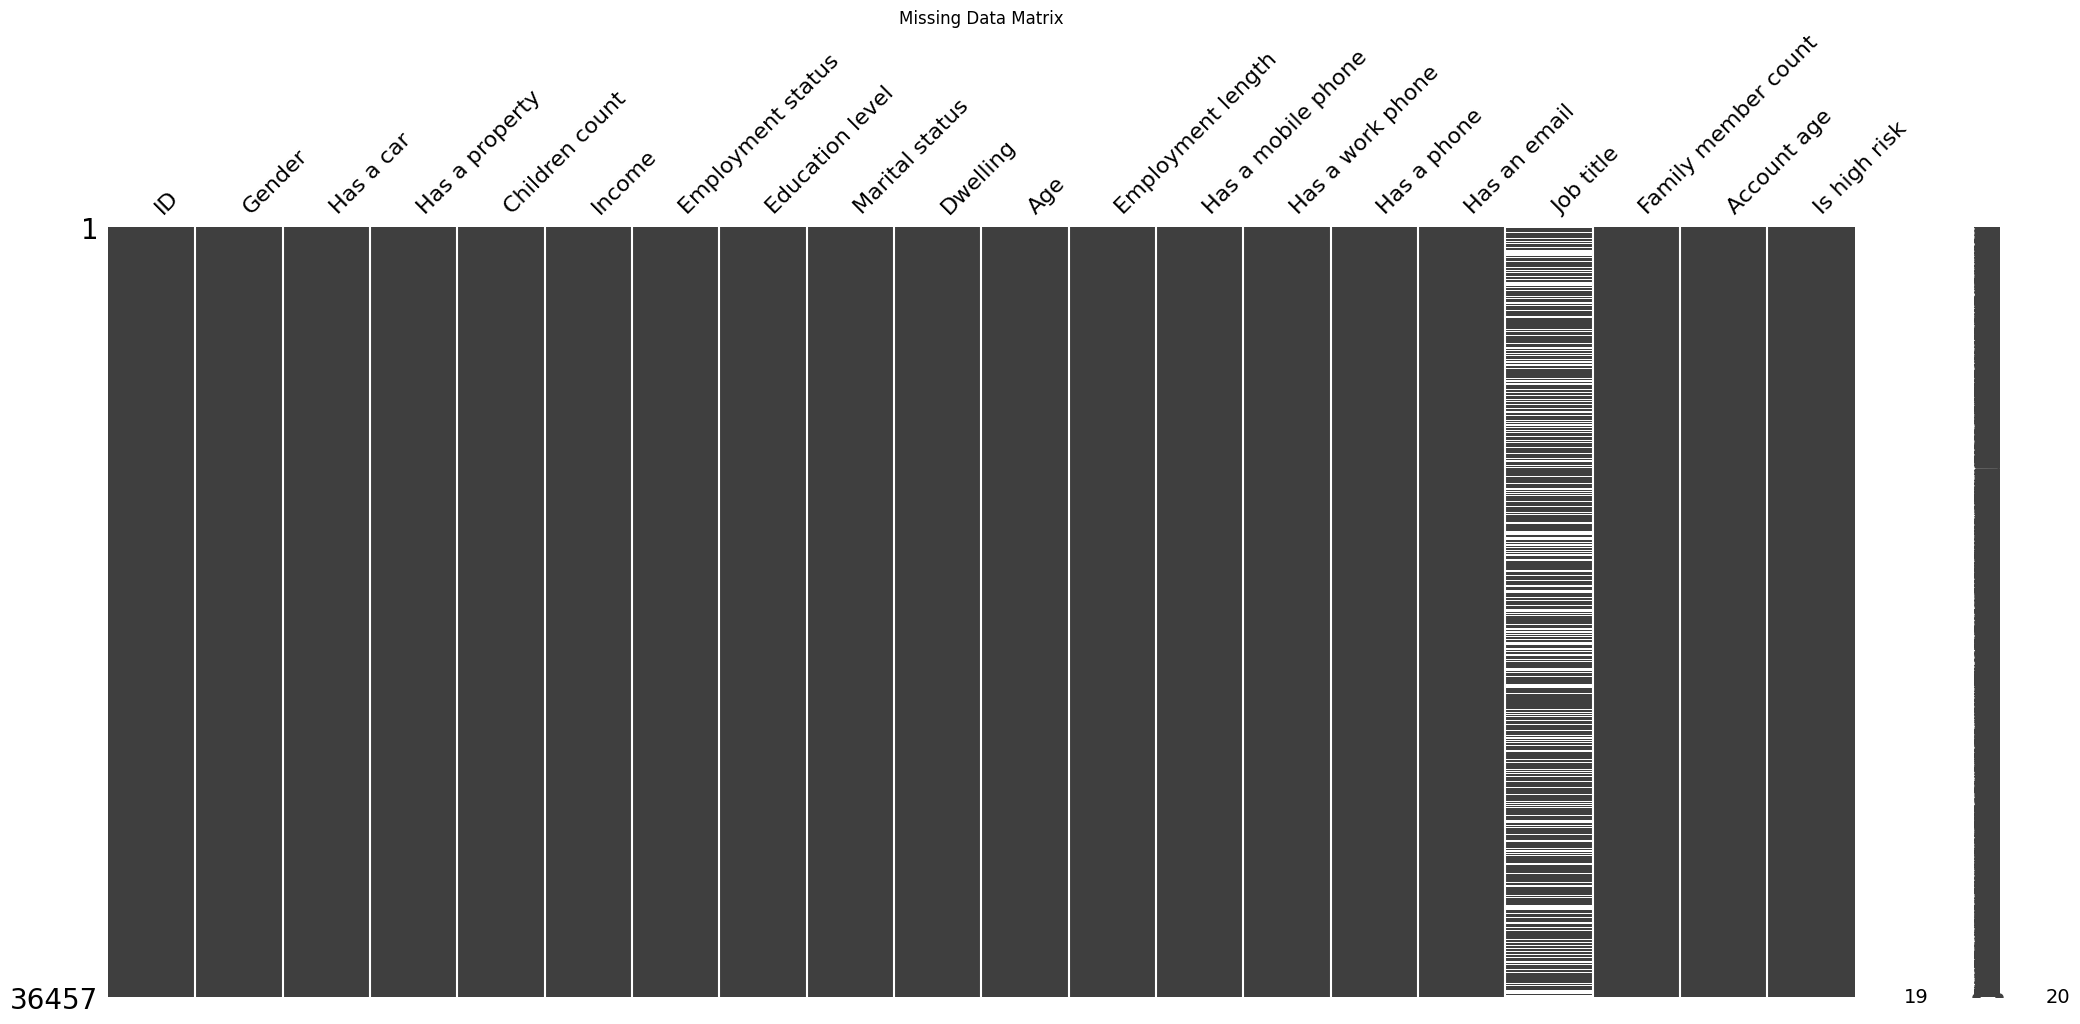

In [867]:
msno.matrix(cc_data_full_data)
plt.title("Missing Data Matrix")
plt.show()

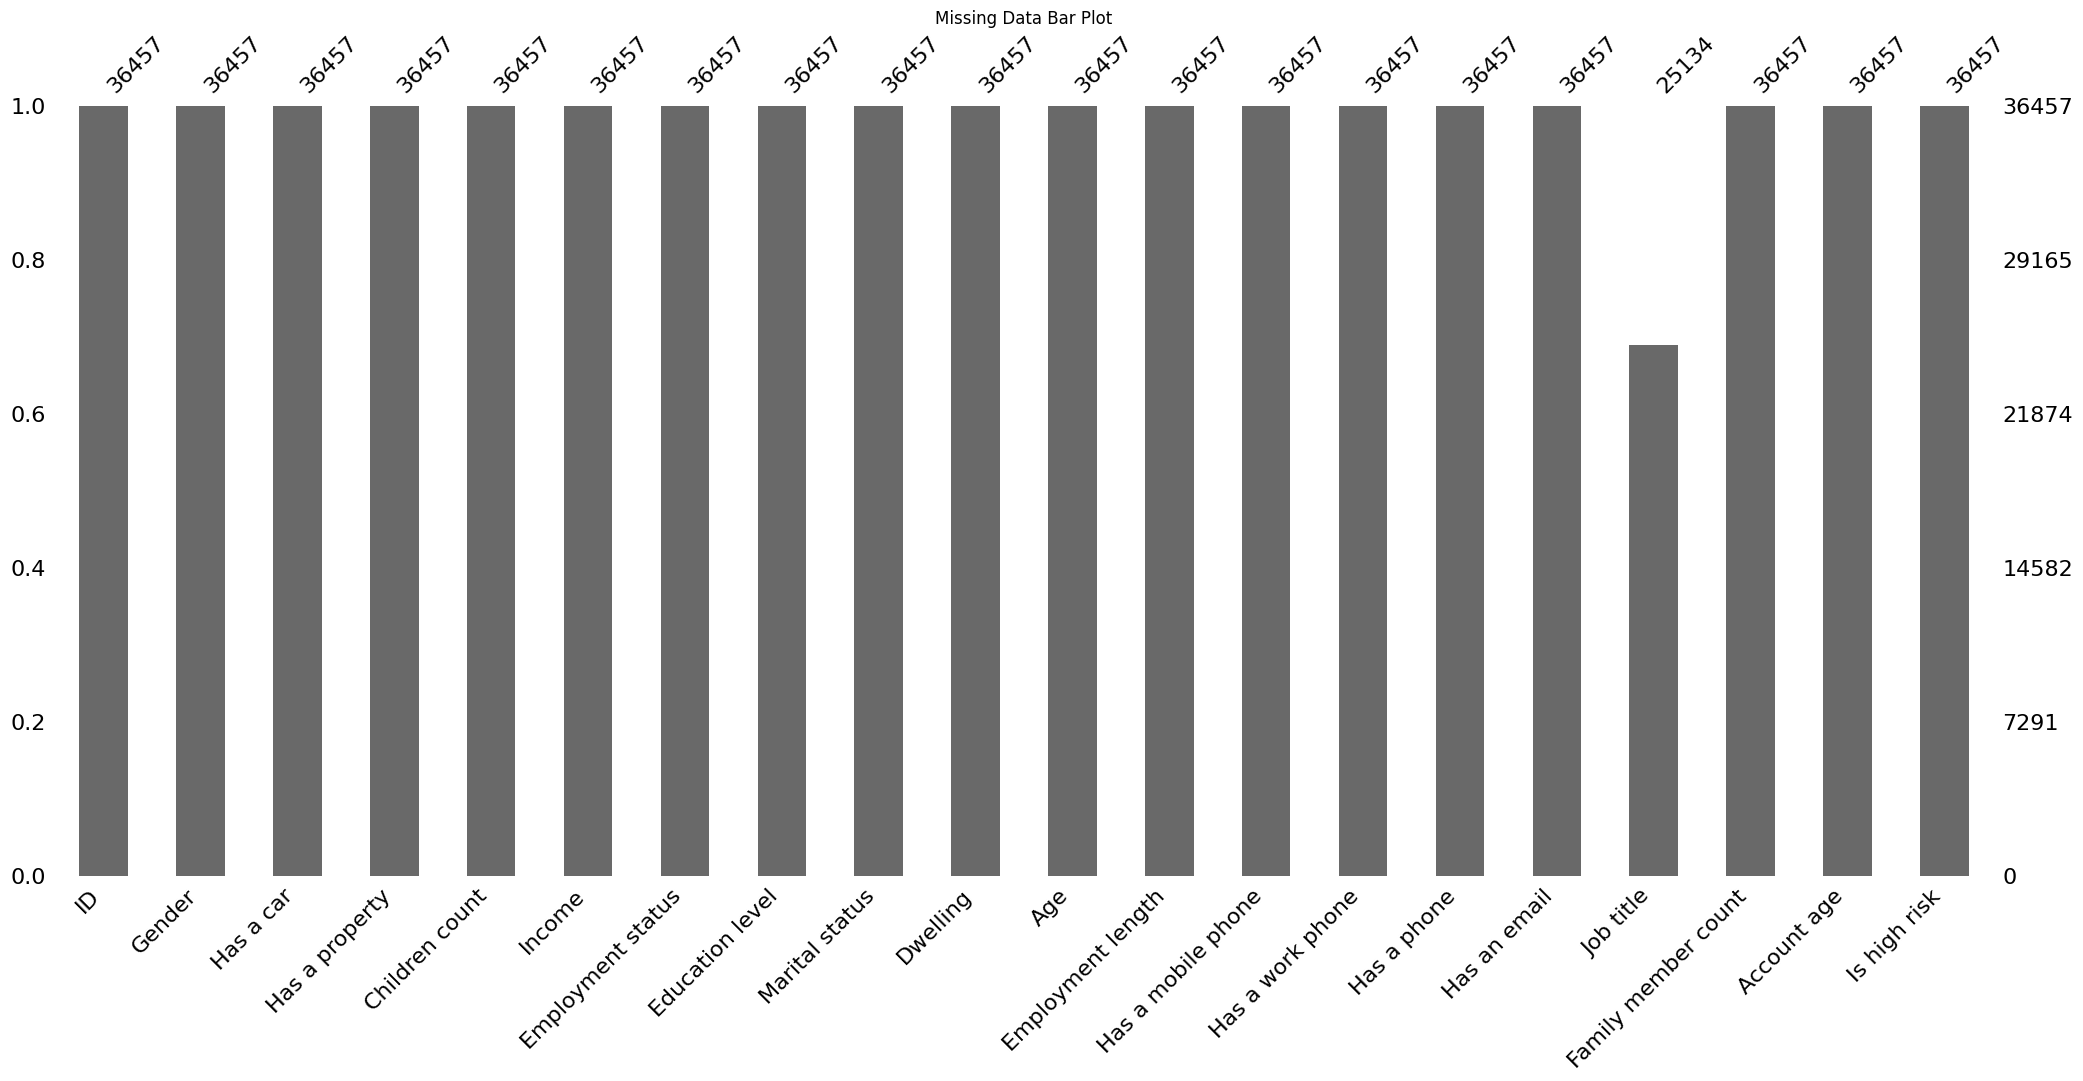

In [868]:
msno.bar(cc_data_full_data)
plt.title("Missing Data Bar Plot")
plt.show()

Funtions used to explore each feature

In [869]:
# function that will return the value count and frequency of each observation within a feature

def value_cnt_norm(df, feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize = True)*100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm],axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [870]:
# function to create display general information about the feature

def gen_info_feat(df, feature):
    match feature:
        case 'Age':
            print(f"Description: \n{((np.abs(df[feature])/365).describe())}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
        case 'Employment Length':
            emp_len = df['Employment length'].loc[df['Employment length']<0]
            emp_len_yrs = np.abs(emp_len)/365.25
            print(f"Description: \n{emp_len_yrs.describe()}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
        case 'Account age':
            print(f"Description: \n{(np.abs(df[feature]).describe())}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
        case _:
            print(f"Description: \n{(df[feature].describe())}")
            print("-"*50)
            print(f'Object type: \n{df[feature].dtype}')
            print("-"*50)
            val_cnt = value_cnt_norm(df,feature)
            print(f'Value count: \n{val_cnt}')


In [871]:
def pie_plot(df, feature):
    match feature:
        case 'Dwelling' | 'Education level':
            ratio_size = value_cnt_norm(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            
            fig, ax = plt.subplots(figsize = (5,5))
            
            plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' : 'black'})
            plt.title(f"Pie chart of {feature}")
            plt.legend(loc='best',labels = ratio_size.index)
            plt.axis('equal')
            return plt.show()
        case _:
            ratio_size = value_cnt_norm(df, feature)
            ratio_size_len = len(ratio_size.index)
            ratio_list = []
            for i in range(ratio_size_len):
                ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
            
            fig, ax = plt.subplots(figsize = (5,5))
            
            plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' : 'black'})
            plt.title(f"Pie chart of {feature}")
            plt.legend(loc='best',labels = ratio_size.index)
            plt.axis('equal')
            return plt.show()

In [872]:
def bar_plot(df, feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize = (2,5))
            sns.barplot(x=value_cnt_norm(df, feature).index, y=value_cnt_norm(df, feature).values[:,0])
            ax.set_xticklabels(labels = value_cnt_norm(df, feature).index, rotation=45, ha='right')
            plt.xlabel(f"{feature}")
            plt.ylabel('Count')
            plt.title(f"{feature} count")
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize = (2,5))
            sns.barplot(x=value_cnt_norm(df,feature).index, y=value_cnt_norm(df,feature).values[:,0])
            plt.xlabel(f"{feature}")
            plt.ylabel('Count')
            plt.title(f"{feature} count")
            return plt.show()

In [873]:
def box_plot(df, feature):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize = (2, 5))
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title(f"{feature} boxplot")
            return plt.show()
        case 'Employment length':
            fig, ax = plt.subplots(figsize = (2, 5))
            emp_len_no_ret = df[feature].loc[df[feature]<0]
            emp_len_no_ret_yrs = np.abs(emp_len_no_ret)/365.25
            sns.boxplot(y=emp_len_no_ret_yrs)
            plt.title(f"{feature} boxplot")
            plt.yticks(np.arange(0,emp_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize = (2,5))
            sns.boxplot(y=df[feature])
            plt.title(f"{feature} boxplot")
            # supress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize = (2, 5))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title(f"{feature} boxplot")
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize = (2, 5))
            sns.boxplot(y=np.abs(df[feature]))
            plt.title(f"{feature} boxplot")
            return plt.show()

In [874]:
def hist_plot(df, feature, bins= 50):
    match feature:
        case 'Age':
            fig, ax = plt.subplots(figsize=(8,5))
            # change the feature so it could be expressed in positive numbers
            sns.histplot(np.abs(df[feature])/365.25, bins=bins, kde=True)
            plt.title(f"{feature} distribution")
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize = (8,5))
            sns.histplot(df[feature], bins=bins, kde=True)
            # supress scientific notaion
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            plt.title(f"{feature} distribution")
        case 'Employment length':
            emp_len_no_ret = df[feature].loc[df[feature]<0]
            emp_len_no_ret_yrs = np.abs(emp_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize = (8,5))
            sns.histplot(emp_len_no_ret_yrs, bins=bins, kde=True)
            plt.title(f"{feature} distribution")
            return plt.show()
        case 'Account age':
            fig, ax = plt.subplots(figsize = (8,5))
            sns.histplot(np.abs(df[feature]), bins=bins, kde=True)
            plt.title(f"{feature} boxplot")
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature], bins=bins,kde=True)
            plt.title(f"{format} distribution")
            return plt.show()

In [875]:
def risk_box_plot(df, feature):
    match feature:
        case 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize = (5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25, x=df['Is high risk'])
            plt.xticks(ticks=[0,1], labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # supress scientif notaion
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
            )
            plt.title(f'High risk individuals grouped by {feature}')
            return plt.show()
        case 'Employment length':
            emp_len_no_ret = df[feature].loc[df[feature]<0]
            emp_len_no_ret_idx = emp_len_no_ret.index
            emp_len_no_ret_yrs = np.abs(emp_len_no_ret)/365.25
            emp_no_ret_df = df.iloc[emp_len_no_ret_idx][['Employment length','Is high risk']]
            emp_no_ret_is_high_risk = emp_no_ret_df.groupby('Is high risk')['Employment length'].mean()
            print(np.abs(emp_no_ret_is_high_risk)/365.25)
            fig, ax = plt.subplots(figsize = (5,8))
            sns.boxplot(y=emp_len_no_ret_yrs, x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title(f"High vs low risk individuals grouped by {feature}")
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize = (5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1], labels=['no', 'yes'])
            plt.title(f"High vs low risk individuals grouped by {feature}")
            return plt.show()            

In [876]:
# High risk vs low risk applicants compared on a bar plot
def risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index, y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index, rotation=45, ha='right')
    plt.ylabel("Count")
    plt.title(f"High risk applicants count grouped by {feature}")
    return plt.show()

# Univariate analysis

## Gender

In [877]:
gen_info_feat(train_copy,'Gender')

Description: 
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
        Count  Frequency (%)
Gender                      
F       19549          67.03
M        9616          32.97


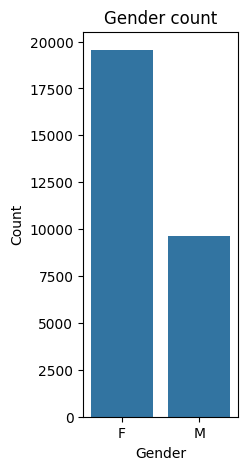

In [878]:
bar_plot(train_copy,'Gender')

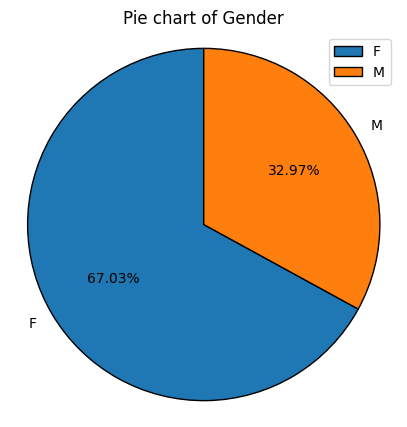

In [879]:
pie_plot(train_copy,'Gender')

### Interpretaion 
- There are more females applicants than male (67% vs 33%)

## Age

In [880]:
gen_info_feat(train_copy, 'Age')

Description: 
count   29165.00
mean       43.78
std        11.52
min        21.11
25%        34.18
50%        42.64
75%        53.27
max        68.91
Name: Age, dtype: float64
--------------------------------------------------
Object type: 
int64


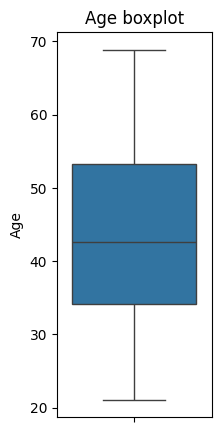

In [881]:
box_plot(train_copy,'Age')

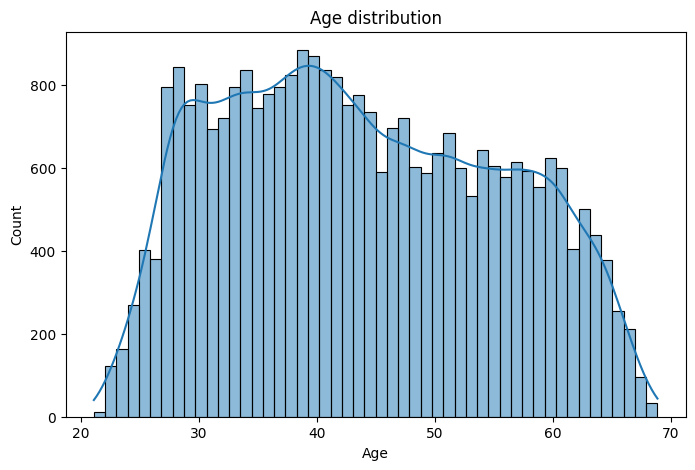

In [882]:
hist_plot(train_copy,'Age')

Is high risk
0   43.75
1   43.54
Name: Age, dtype: float64


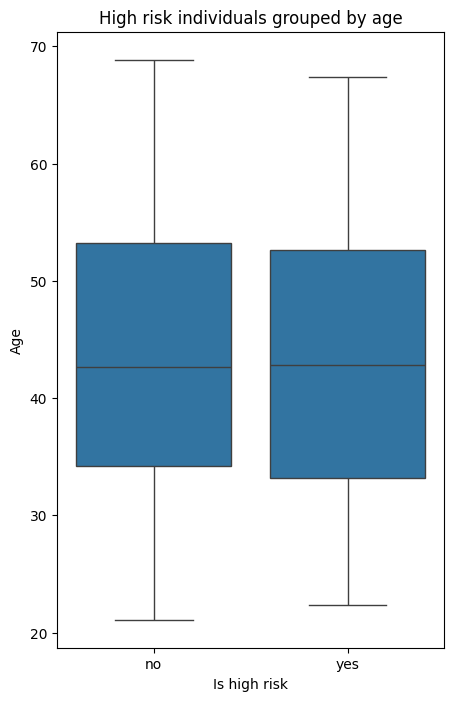

In [883]:
risk_box_plot(train_copy,'Age')

### Interpretaion 
- The youngest applicant is 21 years old whereas the oldest is 68 years old with the average if 43.7 and median of 42.6 (outlier insensitive)
- Age is not normally distributed it is slightly positively skew
- There is not difference between the average age of high and low risk applicants

## Marital status

In [884]:
gen_info_feat(train_copy, 'Marital status')

Description: 
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                      Count  Frequency (%)
Marital status                            
Married               20044          68.73
Single / not married   3864          13.25
Civil marriage         2312           7.93
Separated              1712           5.87
Widow                  1233           4.23


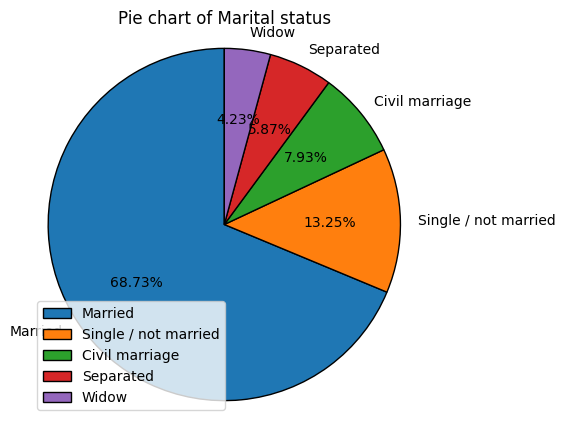

In [885]:
pie_plot(train_copy, 'Marital status')

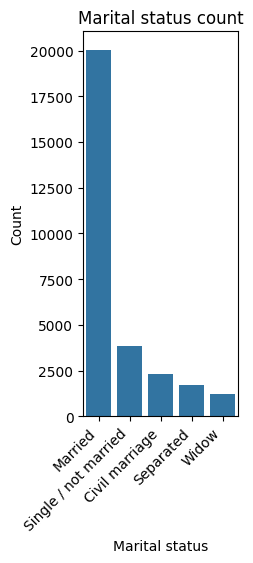

In [886]:
bar_plot(train_copy, 'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


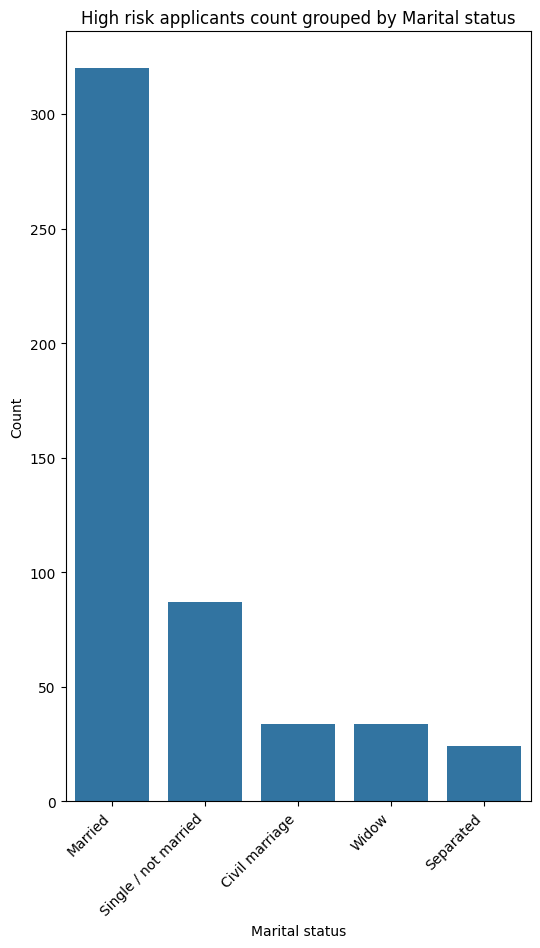

In [887]:
risk_bar_plot(train_copy, 'Marital status')

### Interpretaion

- Most applicants are married
- Even though we have a higher number of applicants who are seperated than those who are widow, it seems like widow applicants are high risk than those who are seperated.

## Family member count

In [888]:
gen_info_feat(train_copy, 'Family member count')

Description: 
count   29165.00
mean        2.20
std         0.91
min         1.00
25%         2.00
50%         2.00
75%         3.00
max        20.00
Name: Family member count, dtype: float64
--------------------------------------------------
Object type: 
float64
--------------------------------------------------
Value count: 
                     Count  Frequency (%)
Family member count                      
2.00                 15552          53.32
1.00                  5613          19.25
3.00                  5121          17.56
4.00                  2503           8.58
5.00                   309           1.06
6.00                    48           0.16
7.00                    14           0.05
9.00                     2           0.01
15.00                    2           0.01
20.00                    1           0.00


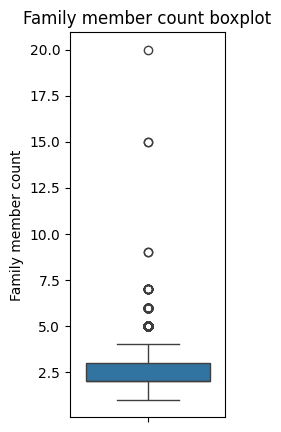

In [889]:
box_plot(train_copy, 'Family member count')

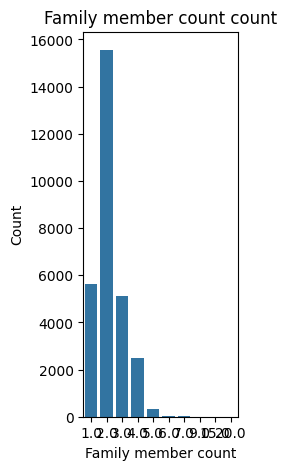

In [890]:
bar_plot(train_copy, 'Family member count')

{2.0: 252, 1.0: 115, 3.0: 85, 4.0: 35, 5.0: 11, 6.0: 1, 7.0: 0, 9.0: 0, 15.0: 0, 20.0: 0}


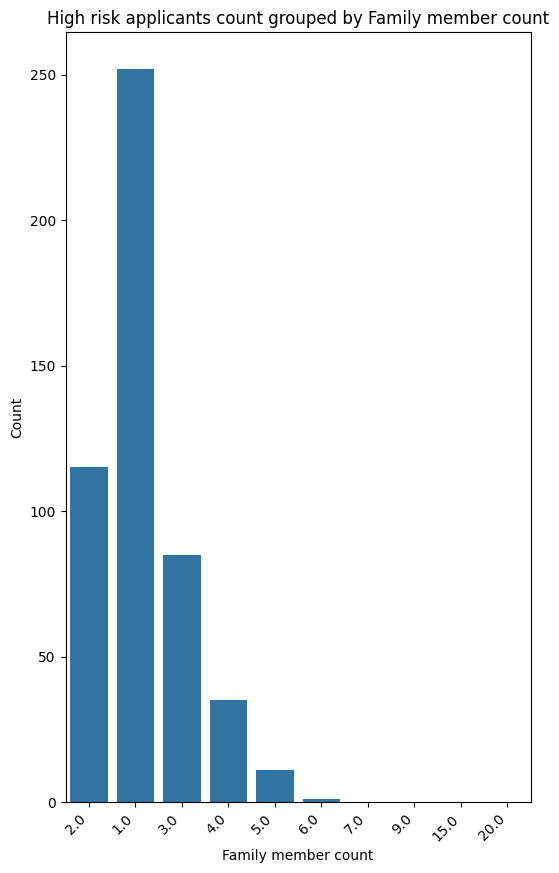

In [985]:
risk_bar_plot(train_copy, 'Family member count')

### Interpreataion
- Most applicants are two in their household, this is also confirmend with the fact that most dont have a child.
- Any number higher than 4 ie 4 family members, is an outlier category.
- Intresting to see that familes having more that two family members are more stable than having one family member

## Children Count

In [891]:
gen_info_feat(train_copy, 'Children count')

Description: 
count   29165.00
mean        0.43
std         0.74
min         0.00
25%         0.00
50%         0.00
75%         1.00
max        19.00
Name: Children count, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                Count  Frequency (%)
Children count                      
0               20143          69.07
1                6003          20.58
2                2624           9.00
3                 323           1.11
4                  52           0.18
5                  15           0.05
7                   2           0.01
14                  2           0.01
19                  1           0.00


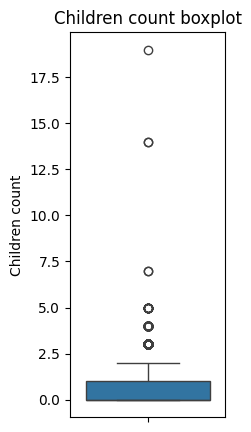

In [892]:
box_plot(train_copy, 'Children count')

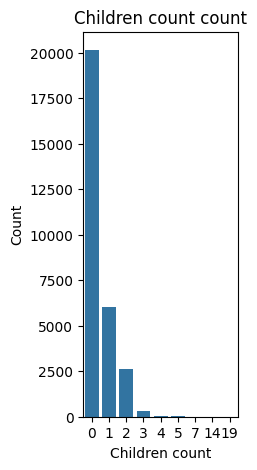

In [893]:
bar_plot(train_copy, 'Children count')

{0: 349, 1: 97, 2: 41, 3: 11, 4: 1, 5: 0, 7: 0, 14: 0, 19: 0}


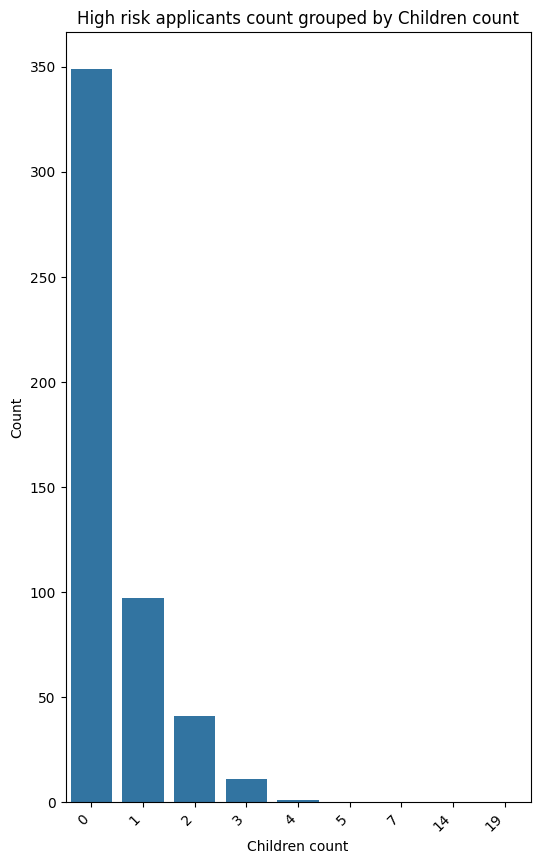

In [986]:
risk_bar_plot(train_copy, 'Children count')

### Interpreataion
- Most applicants dont have a child
- Again we see that familes having children more than 2 are in the outlier categories
- People not having childerens are more risk prone.

## Dwelling type

In [894]:
gen_info_feat(train_copy, 'Dwelling')

Description: 
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                     Count  Frequency (%)
Dwelling                                 
House / apartment    26059          89.35
With parents          1406           4.82
Municipal apartment    912           3.13
Rented apartment       453           1.55
Office apartment       208           0.71
Co-op apartment        127           0.44


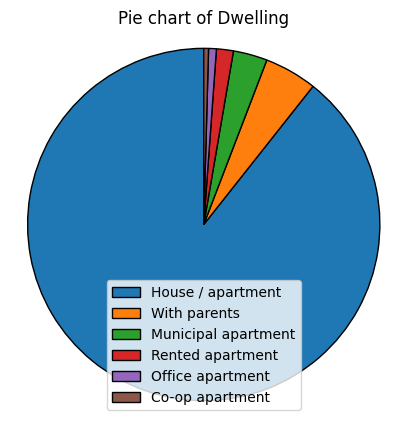

In [895]:
pie_plot(train_copy, 'Dwelling')

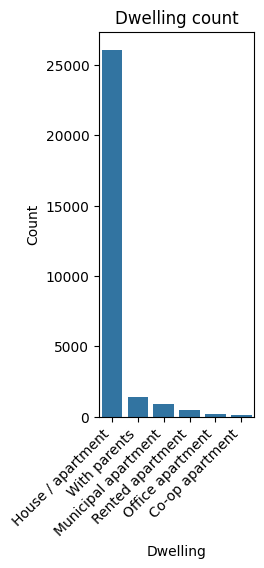

In [896]:
bar_plot(train_copy, 'Dwelling')

{'House / apartment': 437, 'Municipal apartment': 24, 'With parents': 22, 'Rented apartment': 8, 'Office apartment': 6, 'Co-op apartment': 2}


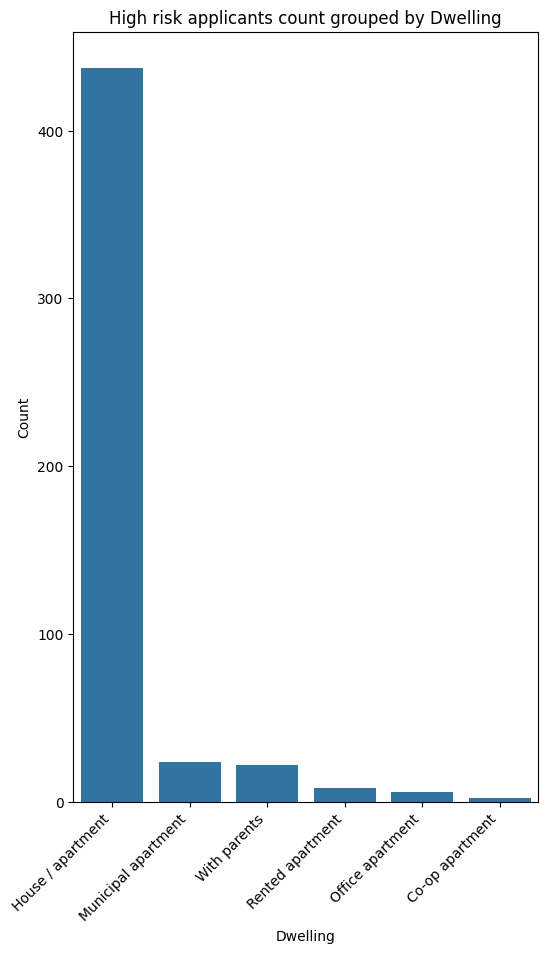

In [987]:
risk_bar_plot(train_copy, 'Dwelling')

Interpreataion
- Almost every applicant live in a house or apartment

## Income

In [897]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(train_copy, 'Income')

Description: 
count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
--------------------------------------------------
Object type: 
float64
--------------------------------------------------
Value count: 
           Count  Frequency (%)
Income                         
135000.00   3468          11.89
180000.00   2487           8.53
157500.00   2469           8.47
225000.00   2373           8.14
112500.00   2359           8.09
...          ...            ...
164250.00      1           0.00
42300.00       1           0.00
432000.00      1           0.00
145350.00      1           0.00
82350.00       1           0.00

[259 rows x 2 columns]


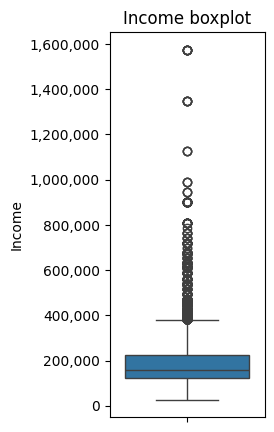

In [898]:
box_plot(train_copy, 'Income')

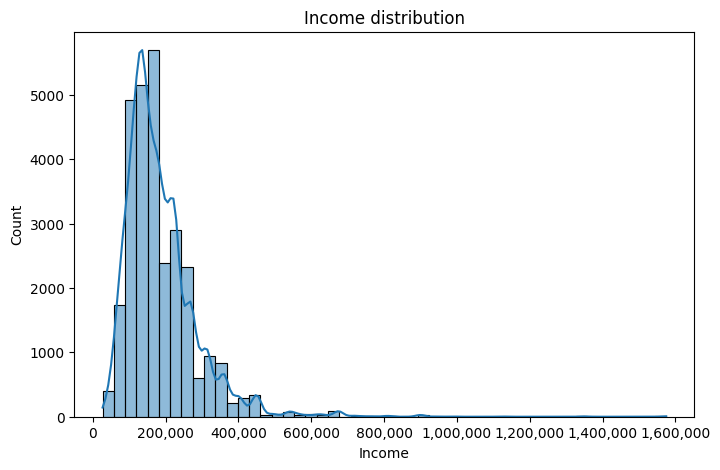

In [899]:
hist_plot(train_copy, 'Income')

Bivariate Analysis with the target variable

Is high risk
0   186913.94
1   185537.26
Name: Income, dtype: float64


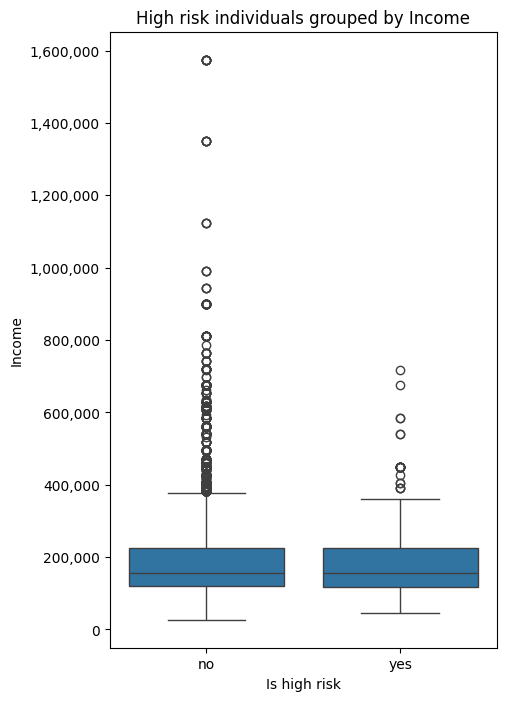

In [900]:
risk_box_plot(train_copy, 'Income')

### Interpreataion

- The minimum and maximum income are 27,000 and 1,575,000 respectively with the mean being 186,890 and median 157,500. Since there are outliers the actual mean would be around the median.
- There are 3 applicants whose income is more than 1,000,000
- The income is positively skewed
- High risk and low risk applicants have roughly similar income

In [901]:
gen_info_feat(train_copy,'Job title')

Description: 
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                       Count  Frequency (%)
Job title                                  
Laborers                5004          24.85
Core staff              2866          14.23
Sales staff             2773          13.77
Managers                2422          12.03
Drivers                 1722           8.55
High skill tech staff   1133           5.63
Accountants              998           4.96
Medicine staff           956           4.75
Cooking staff            521           2.59
Security staff           464           2.30
Cleaning staff           425           2.11
Private service staff    287           1.43
Low-skill Laborers       138           0.69
Waiters/barmen staff     127           0.63
Secretaries              122          

In [902]:
job_title_nan_count = train_copy['Job title'].isna().sum()
job_title_nan_count

9027

In [903]:
rows_total_count = train_copy.shape[0]
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


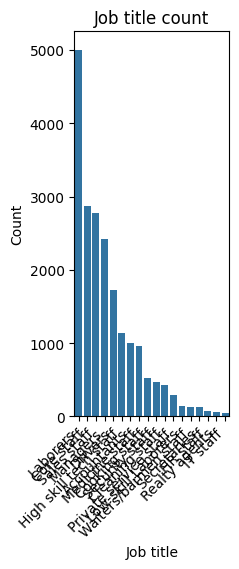

In [904]:
bar_plot(train_copy,'Job title')

### Interpretation:

- The most common job title is laborers by far.
- We have 30.95% if missing data.

# Employment status

In [905]:
gen_info_feat(train_copy,'Employment status')


Description: 
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                      Count  Frequency (%)
Employment status                         
Working               15056          51.62
Commercial associate   6801          23.32
Pensioner              4920          16.87
State servant          2381           8.16
Student                   7           0.02


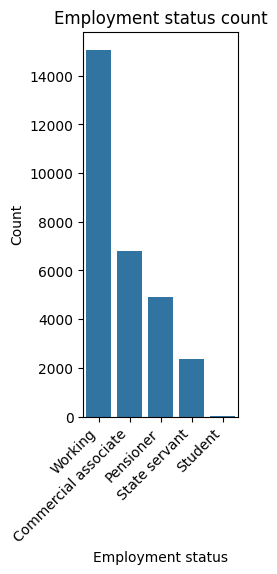

In [906]:
bar_plot(train_copy,'Employment status')


{'Working': 254, 'Commercial associate': 114, 'Pensioner': 103, 'State servant': 28, 'Student': 0}


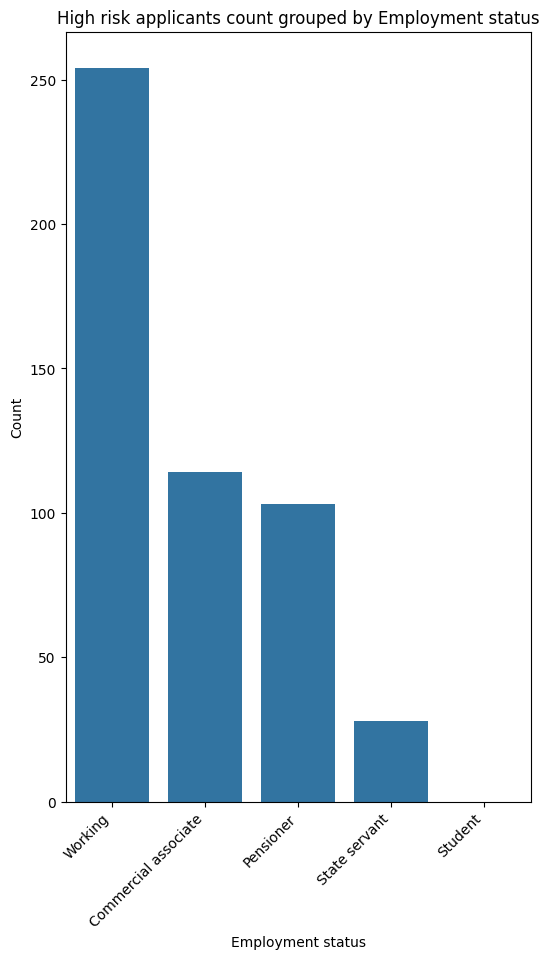

In [988]:
risk_bar_plot(train_copy,'Employment status')

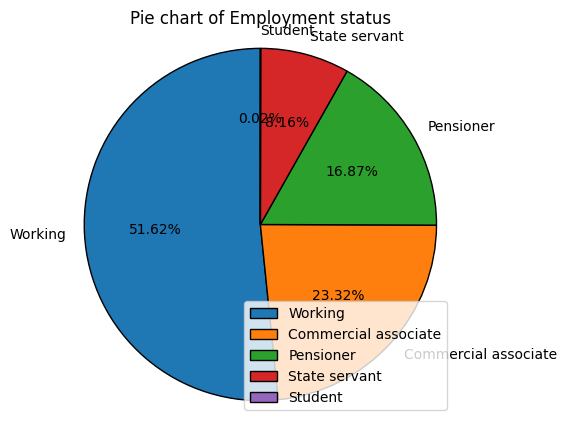

In [907]:
pie_plot(train_copy,'Employment status')

### Interpretation:

- Most applicants are employed

# Education level

In [908]:
gen_info_feat(train_copy,'Education level')

Description: 
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                               Count  Frequency (%)
Education level                                    
Secondary / secondary special  19803          67.90
Higher education                7910          27.12
Incomplete higher               1129           3.87
Lower secondary                  298           1.02
Academic degree                   25           0.09


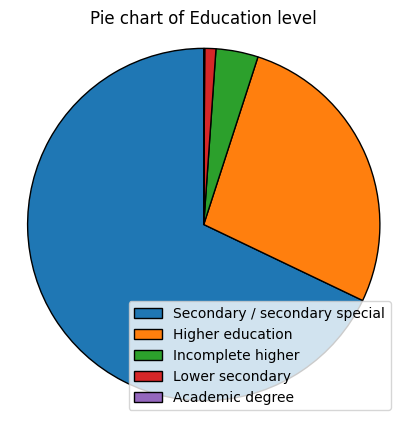

In [909]:
pie_plot(train_copy,'Education level')


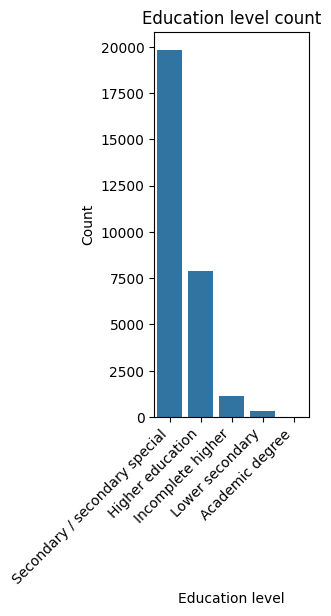

In [910]:
bar_plot(train_copy,'Education level')


{'Secondary / secondary special': 331, 'Higher education': 135, 'Incomplete higher': 24, 'Lower secondary': 9, 'Academic degree': 0}


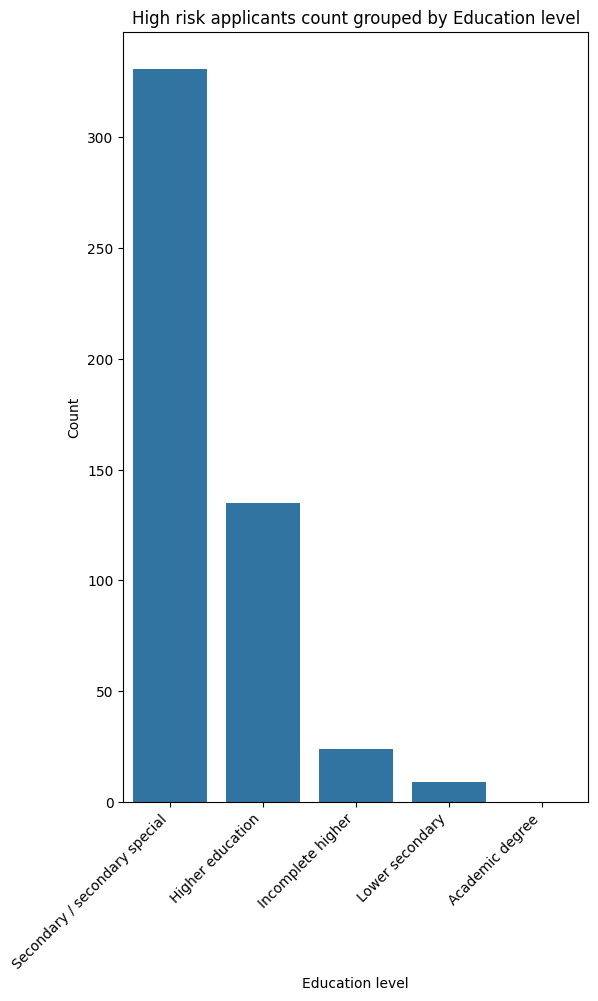

In [989]:
risk_bar_plot(train_copy,'Education level')

### Interpretation:

- The majority of applicants have completed their secondary degree, ¼ completed their higher education.

# Employment length

In [990]:
gen_info_feat(train_copy,'Employment length')

Description: 
count    29165.00
mean     59257.76
std     137655.88
min     -15713.00
25%      -3153.00
50%      -1557.00
75%       -412.00
max     365243.00
Name: Employment length, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                   Count  Frequency (%)
Employment length                      
 365243             4908          16.83
-401                  61           0.21
-200                  55           0.19
-2087                 53           0.18
-1539                 51           0.17
...                  ...            ...
-8369                  1           0.00
-6288                  1           0.00
-6303                  1           0.00
-3065                  1           0.00
-8256                  1           0.00

[3483 rows x 2 columns]


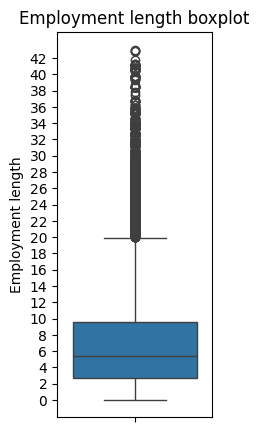

In [991]:
box_plot(train_copy,'Employment length')

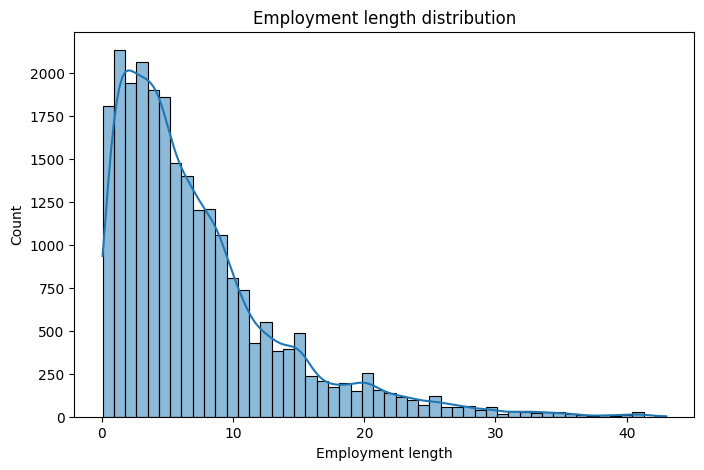

In [913]:
hist_plot(train_copy,'Employment length')


Bivariate analysis with target variable

Is high risk
0   7.29
1   5.75
Name: Employment length, dtype: float64


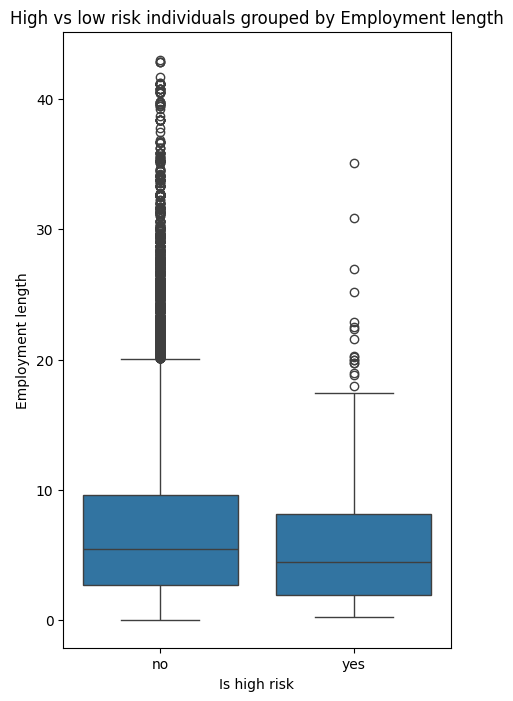

In [914]:
risk_box_plot(train_copy,'Employment length')

### Interpretation:

- Most of applicant have been working for 5 to 7 years on average
- We have quite a number of outliers who have been working for more than 20 years+
- The employment length is positively skewed
- Those who are high risk have a low employment length of 5 versus 7 years for the low risk

# Has a car

In [915]:
gen_info_feat(train_copy,'Has a car')

Description: 
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
           Count  Frequency (%)
Has a car                      
N          18128          62.16
Y          11037          37.84


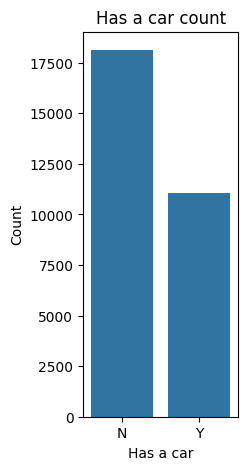

In [994]:
bar_plot(train_copy,'Has a car')

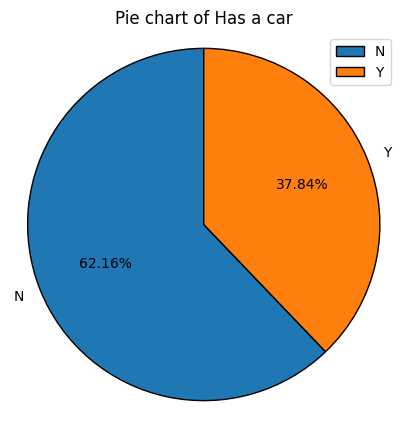

In [917]:
pie_plot(train_copy,'Has a car')


### Interpretation:

- Most applicant don’t own a car.

# Has a property

In [918]:
gen_info_feat(train_copy,'Has a property')


Description: 
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
                Count  Frequency (%)
Has a property                      
Y               19557          67.06
N                9608          32.94


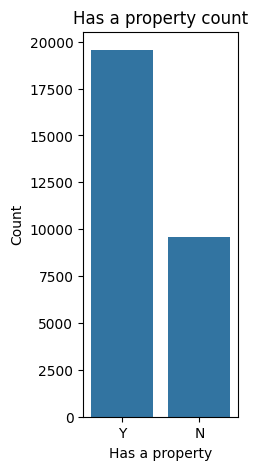

In [995]:
bar_plot(train_copy,'Has a property')

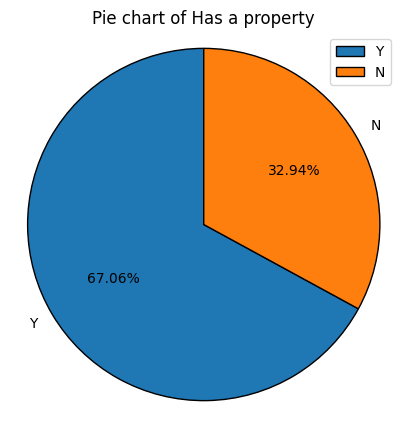

In [996]:
pie_plot(train_copy,'Has a property')

### Interpretation:

- Most applicants own a property.

# Has a work phone

In [921]:
gen_info_feat(train_copy,'Has a work phone')


Description: 
count   29165.00
mean        0.22
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                  Count  Frequency (%)
Has a work phone                      
0                 22623          77.57
1                  6542          22.43


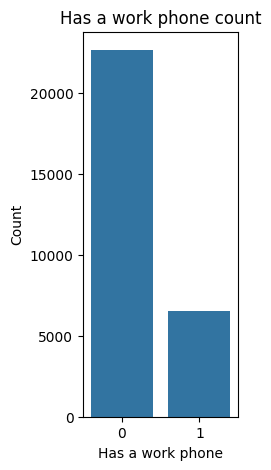

In [922]:
bar_plot(train_copy,'Has a work phone')


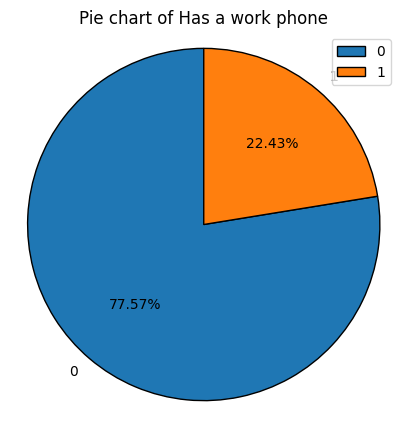

In [923]:
pie_plot(train_copy,'Has a work phone')


### Interpretation:

- More than ¾ of applicants don’t have a work phone.

# Has a mobile phone

In [924]:
gen_info_feat(train_copy,'Has a mobile phone')


Description: 
count   29165.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
                    Count  Frequency (%)
Has a mobile phone                      
1                   29165         100.00


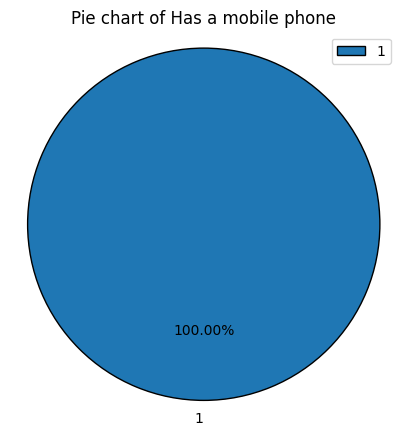

In [925]:
pie_plot(train_copy,'Has a mobile phone')


### Interpretation:

- All the applicants without exception have a mobile phone.

# Has a phone

In [926]:
gen_info_feat(train_copy,'Has a phone')


Description: 
count   29165.00
mean        0.29
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
             Count  Frequency (%)
Has a phone                      
0            20562          70.50
1             8603          29.50


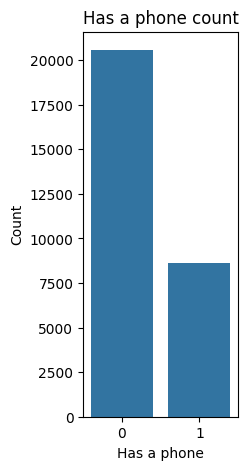

In [927]:
bar_plot(train_copy,'Has a phone')


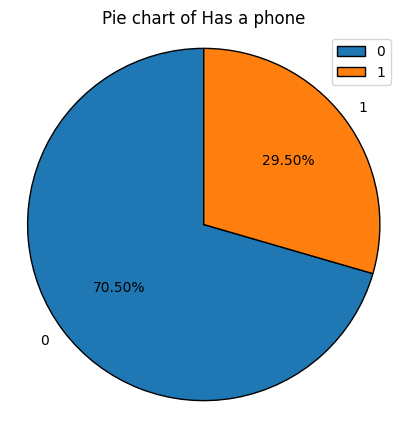

In [928]:
pie_plot(train_copy,'Has a phone')


### Interpretation:

- Most applicants don’t have a phone (probably a home phone).

# Has an email

In [929]:
gen_info_feat(train_copy,'Has an email')


Description: 
count   29165.00
mean        0.09
std         0.29
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
--------------------------------------------------
Object type: 
int64
--------------------------------------------------
Value count: 
              Count  Frequency (%)
Has an email                      
0             26532          90.97
1              2633           9.03


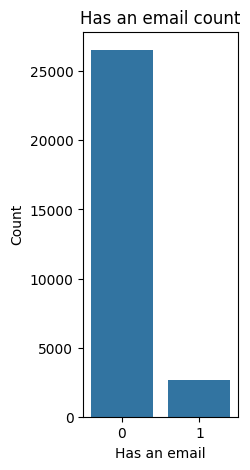

In [930]:
bar_plot(train_copy,'Has an email')


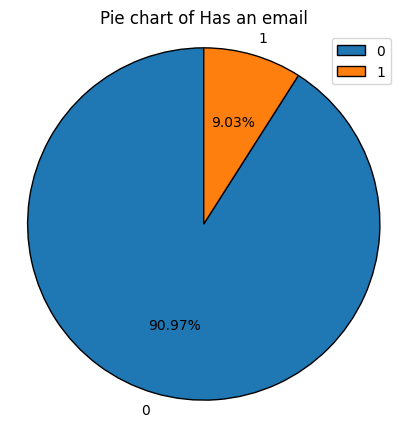

In [931]:
pie_plot(train_copy,'Has an email')


### Interpretation:

- More than 90% of applicants don’t have an email.

# Account age

In [932]:
gen_info_feat(train_copy,'Account age')

Description: 
count   29165.00
mean       26.14
std        16.49
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age, dtype: float64
--------------------------------------------------
Object type: 
float64


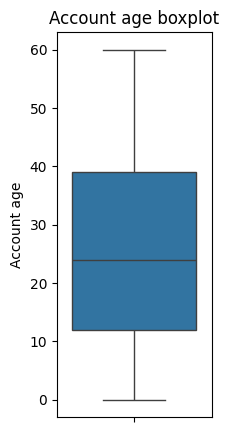

In [933]:
box_plot(train_copy,'Account age')


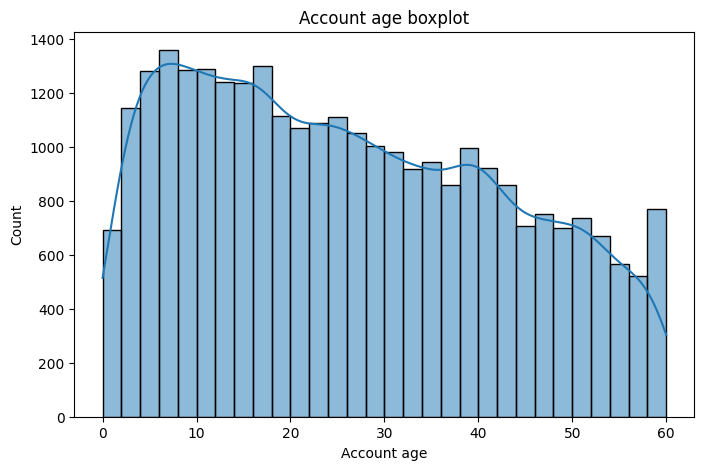

In [934]:
hist_plot(train_copy,'Account age', bins=30)


Is high risk
0   26.00
1   34.04
Name: Account age, dtype: float64


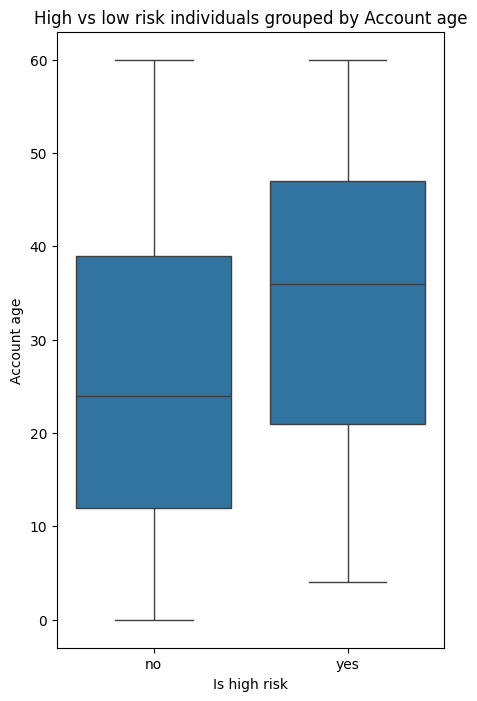

In [935]:
risk_box_plot(train_copy,'Account age')


### Interpretation:

- Most accounts are 26 months old
- Account age is not normally distributed, it is positively skewed
- The accounts that have been flagged as high risk are on average 34 months old vs 26 months old for old account

# Is high risk (target variable)

In [936]:
gen_info_feat(train_copy,'Is high risk')


Description: 
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
--------------------------------------------------
Object type: 
object
--------------------------------------------------
Value count: 
              Count  Frequency (%)
Is high risk                      
0             28666          98.29
1               499           1.71


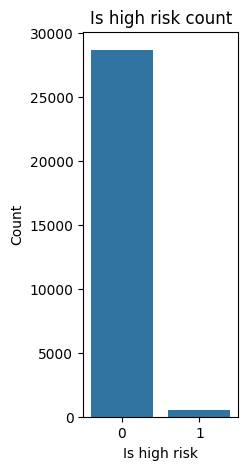

In [937]:
bar_plot(train_copy,'Is high risk')


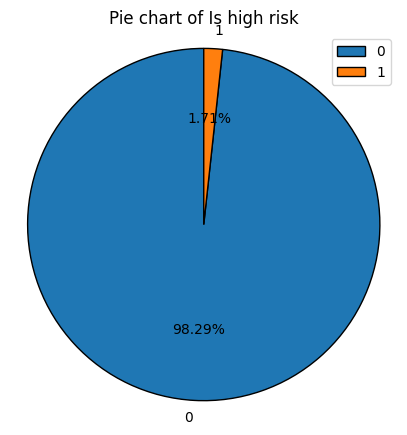

In [938]:
pie_plot(train_copy,'Is high risk')


### Interpretation:

- A vast majority of applicants are low risk applicants.
- We have a very imbalance data.

# Bivariate analysis

## Numerical vs numerical features 

### Scatter plots

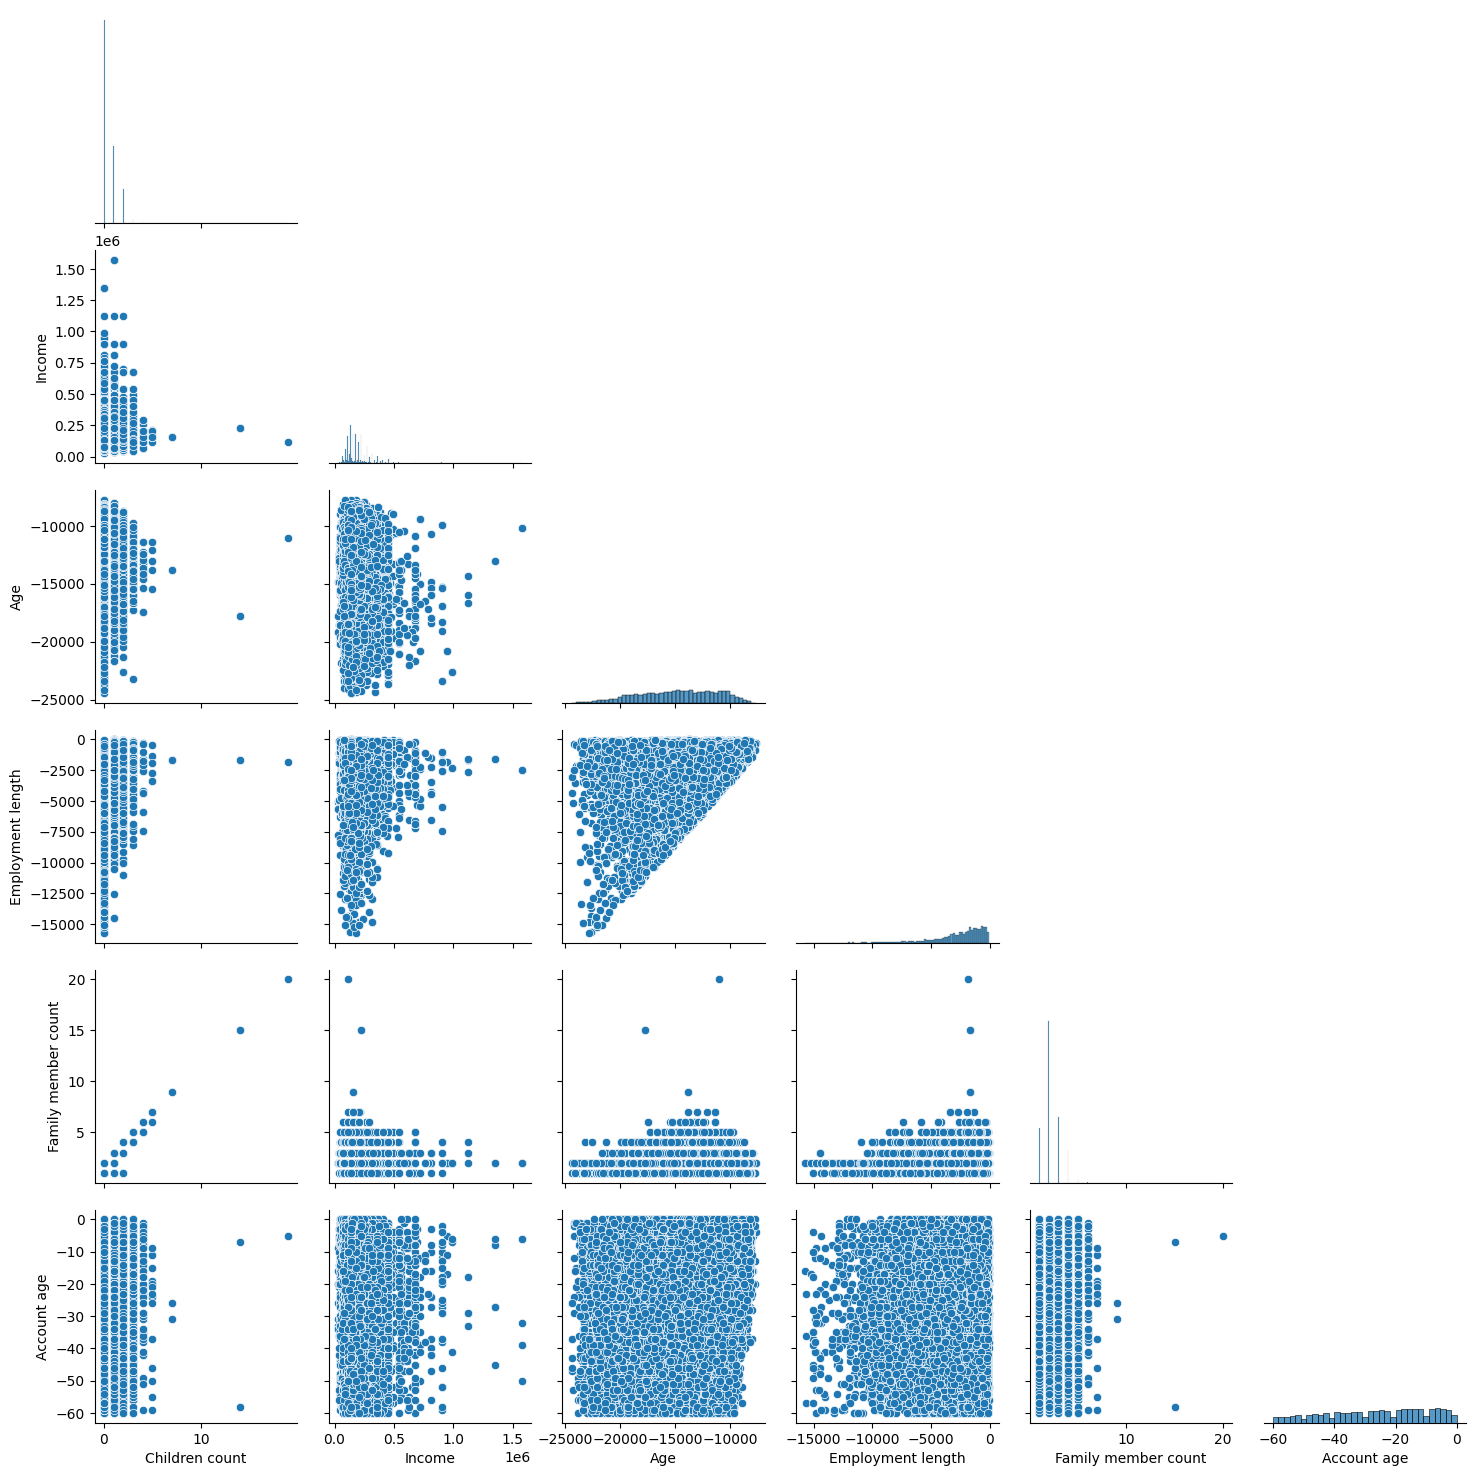

In [939]:
sns.pairplot(train_copy[train_copy['Employment length'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

### Interpretation

- We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member coubt. This is a multicolinearity problem, meaning that the features are highly correleated. We will need to drop one of them.
- Another intesting trend is the Employment length and age. This also makes sense, the longer the employee has been working the older they are.
- Also we observe that the income stays mostly stagnant with the age except for some individuals.

Family member count vs children count (numerical vs numerical feature comparison)

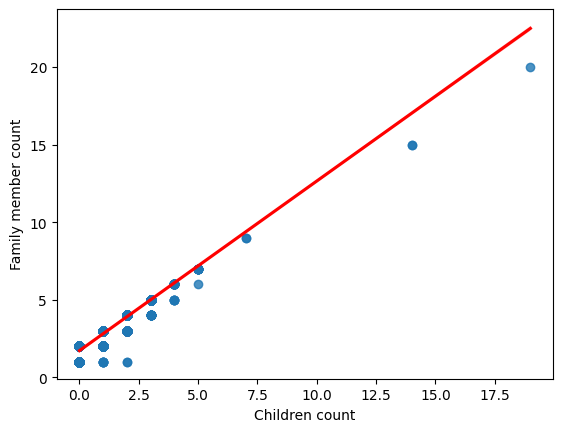

In [940]:
sns.regplot(x='Children count',y='Family member count',data=train_copy,line_kws={'color': 'red'})
plt.show()

### Interpretation:

- The more children a person has, the larger the family member count.

Account age vs age (numerical vs numerical feature comparison)

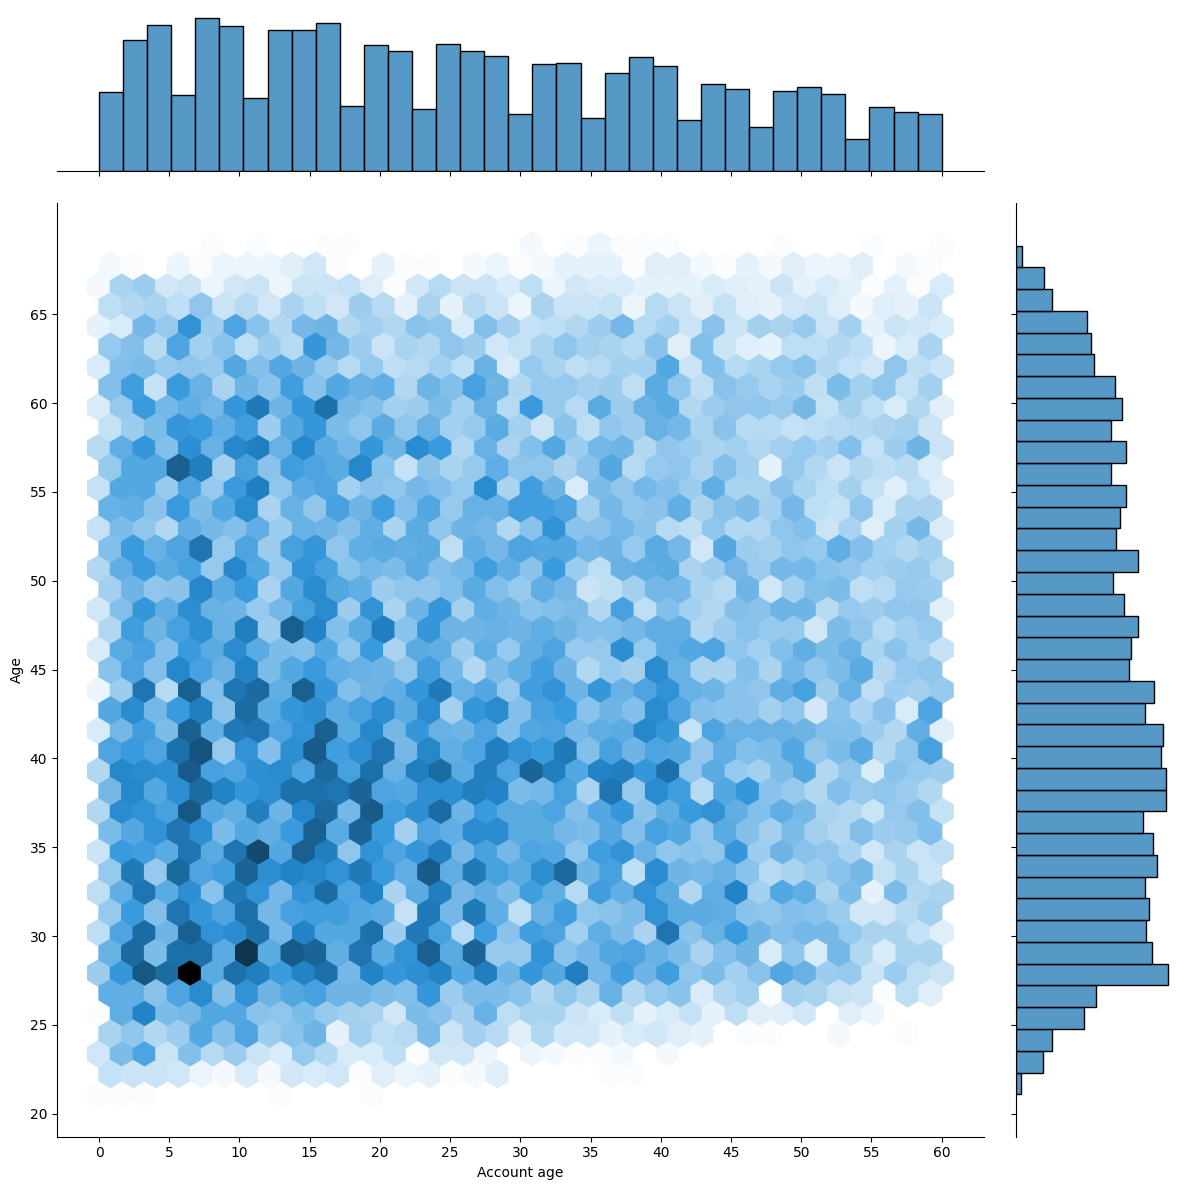

In [941]:
y_age = np.abs(train_copy['Age'])/365.25
sns.jointplot(x= np.abs(train_copy['Account age']),y=y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

# Interpretation:

- Most of the applicants are between 20 and 45 years old and have an account that is less than 25 months old.

Employment length vs age (numerical vs numerical feature comparison)

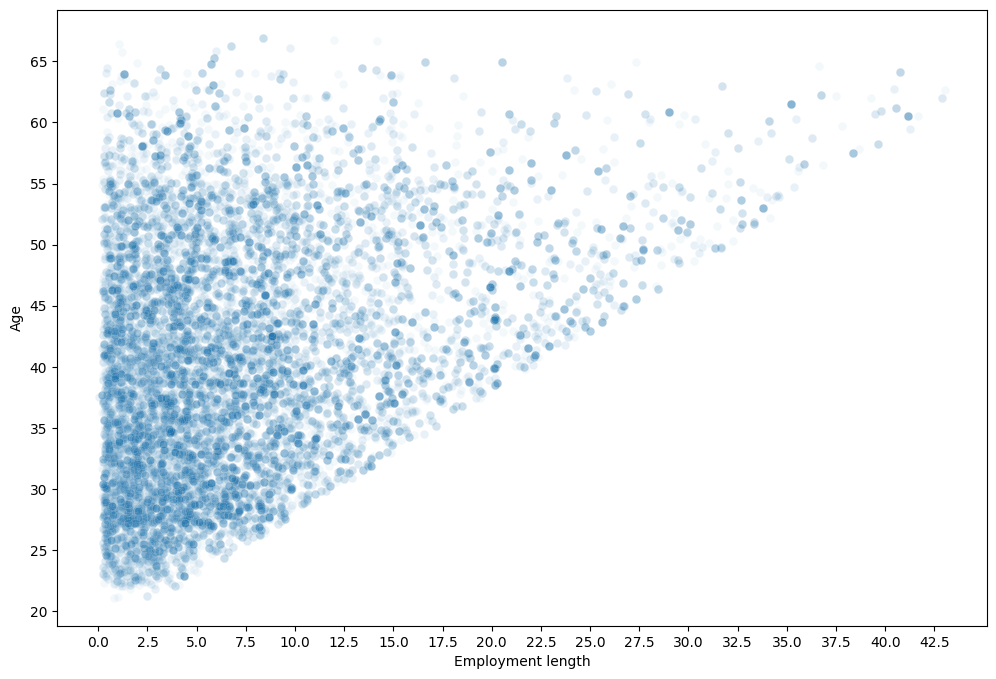

In [942]:
x_employ_length = np.abs(train_copy[train_copy['Employment length'] < 0]['Employment length'])/365.25
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x= x_employ_length,y = y_age,alpha=.05)
# change the frequency of the x-axis and y-axis labels
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

### Interpretation:

- This scatterplot shows that the age of the applicants is correlated with the length of employment. The reason why it is shpared like reverse traiangle, it is because the age of applicants increases with the length of employment. The employment length cannot be greater than age ie employment length > the age.

Correlation analysis

In [943]:
# change the datatype of target feature to int
is_high_risk_int = train_copy['Is high risk'].astype('int32')

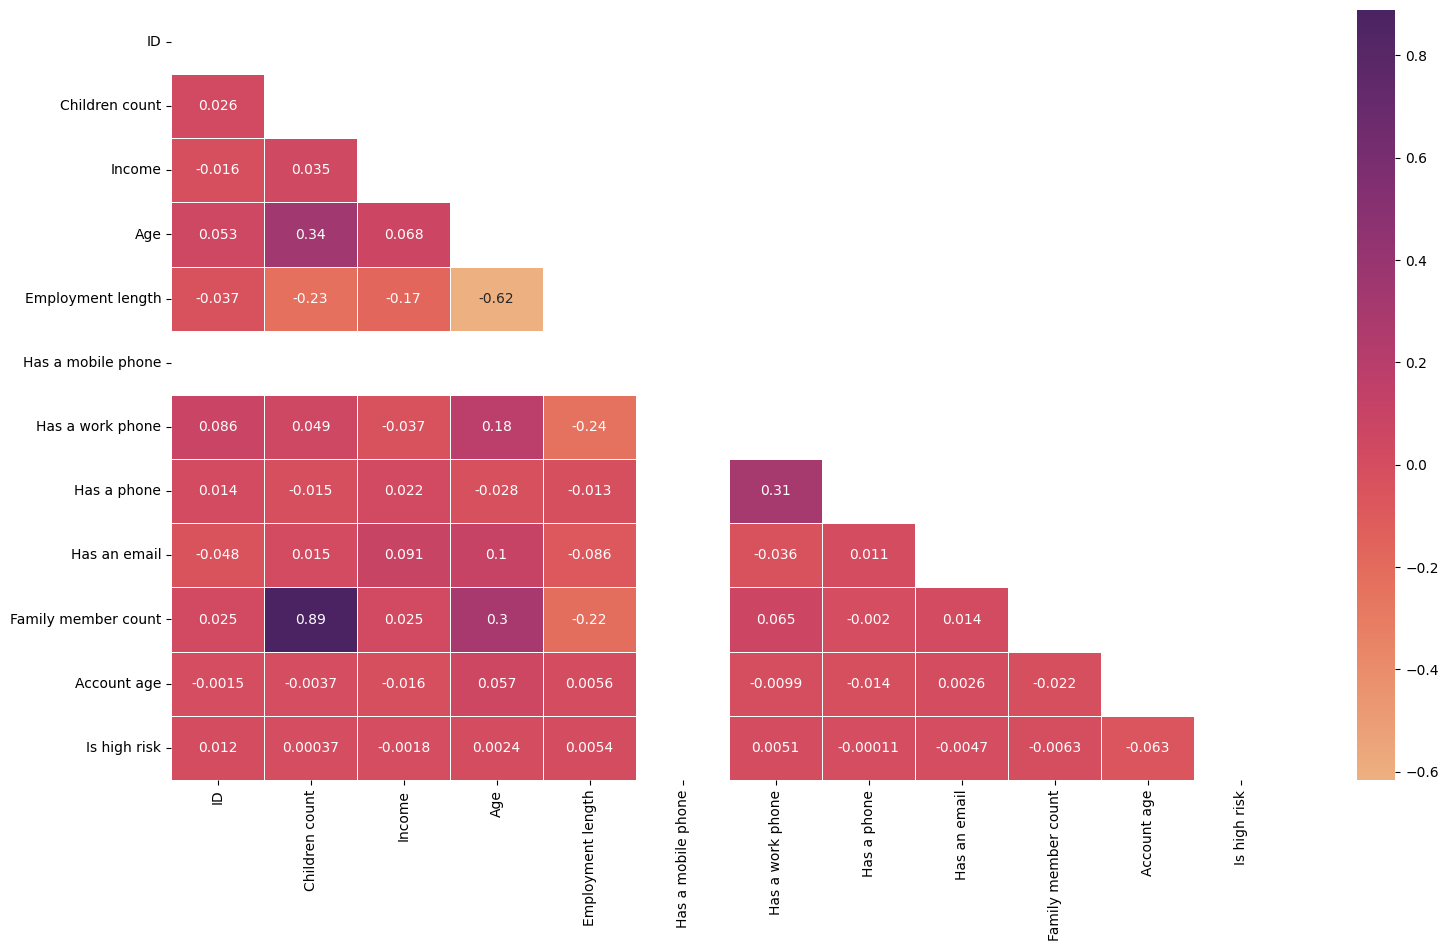

In [944]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile = pd.concat([train_copy.drop(train_copy.select_dtypes(include=['object']).columns, axis=1),is_high_risk_int],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

### Interpreatation

- There is no feature which is correlated with the target variable.
- Family member count is highly correataed with children count as disscussed previously.
- Age has some positive correlation with the family member count and children count. The older the person is the most likely he/she will have a larger family.
- There is some positive correlation between has a work phone and has a phone.
- Age and employment length has a negative correleation which is what we discussed, employment length is correlated with age.

## Numerical vs categorical features (ANOVA)

### Age vs the rest of categorical features

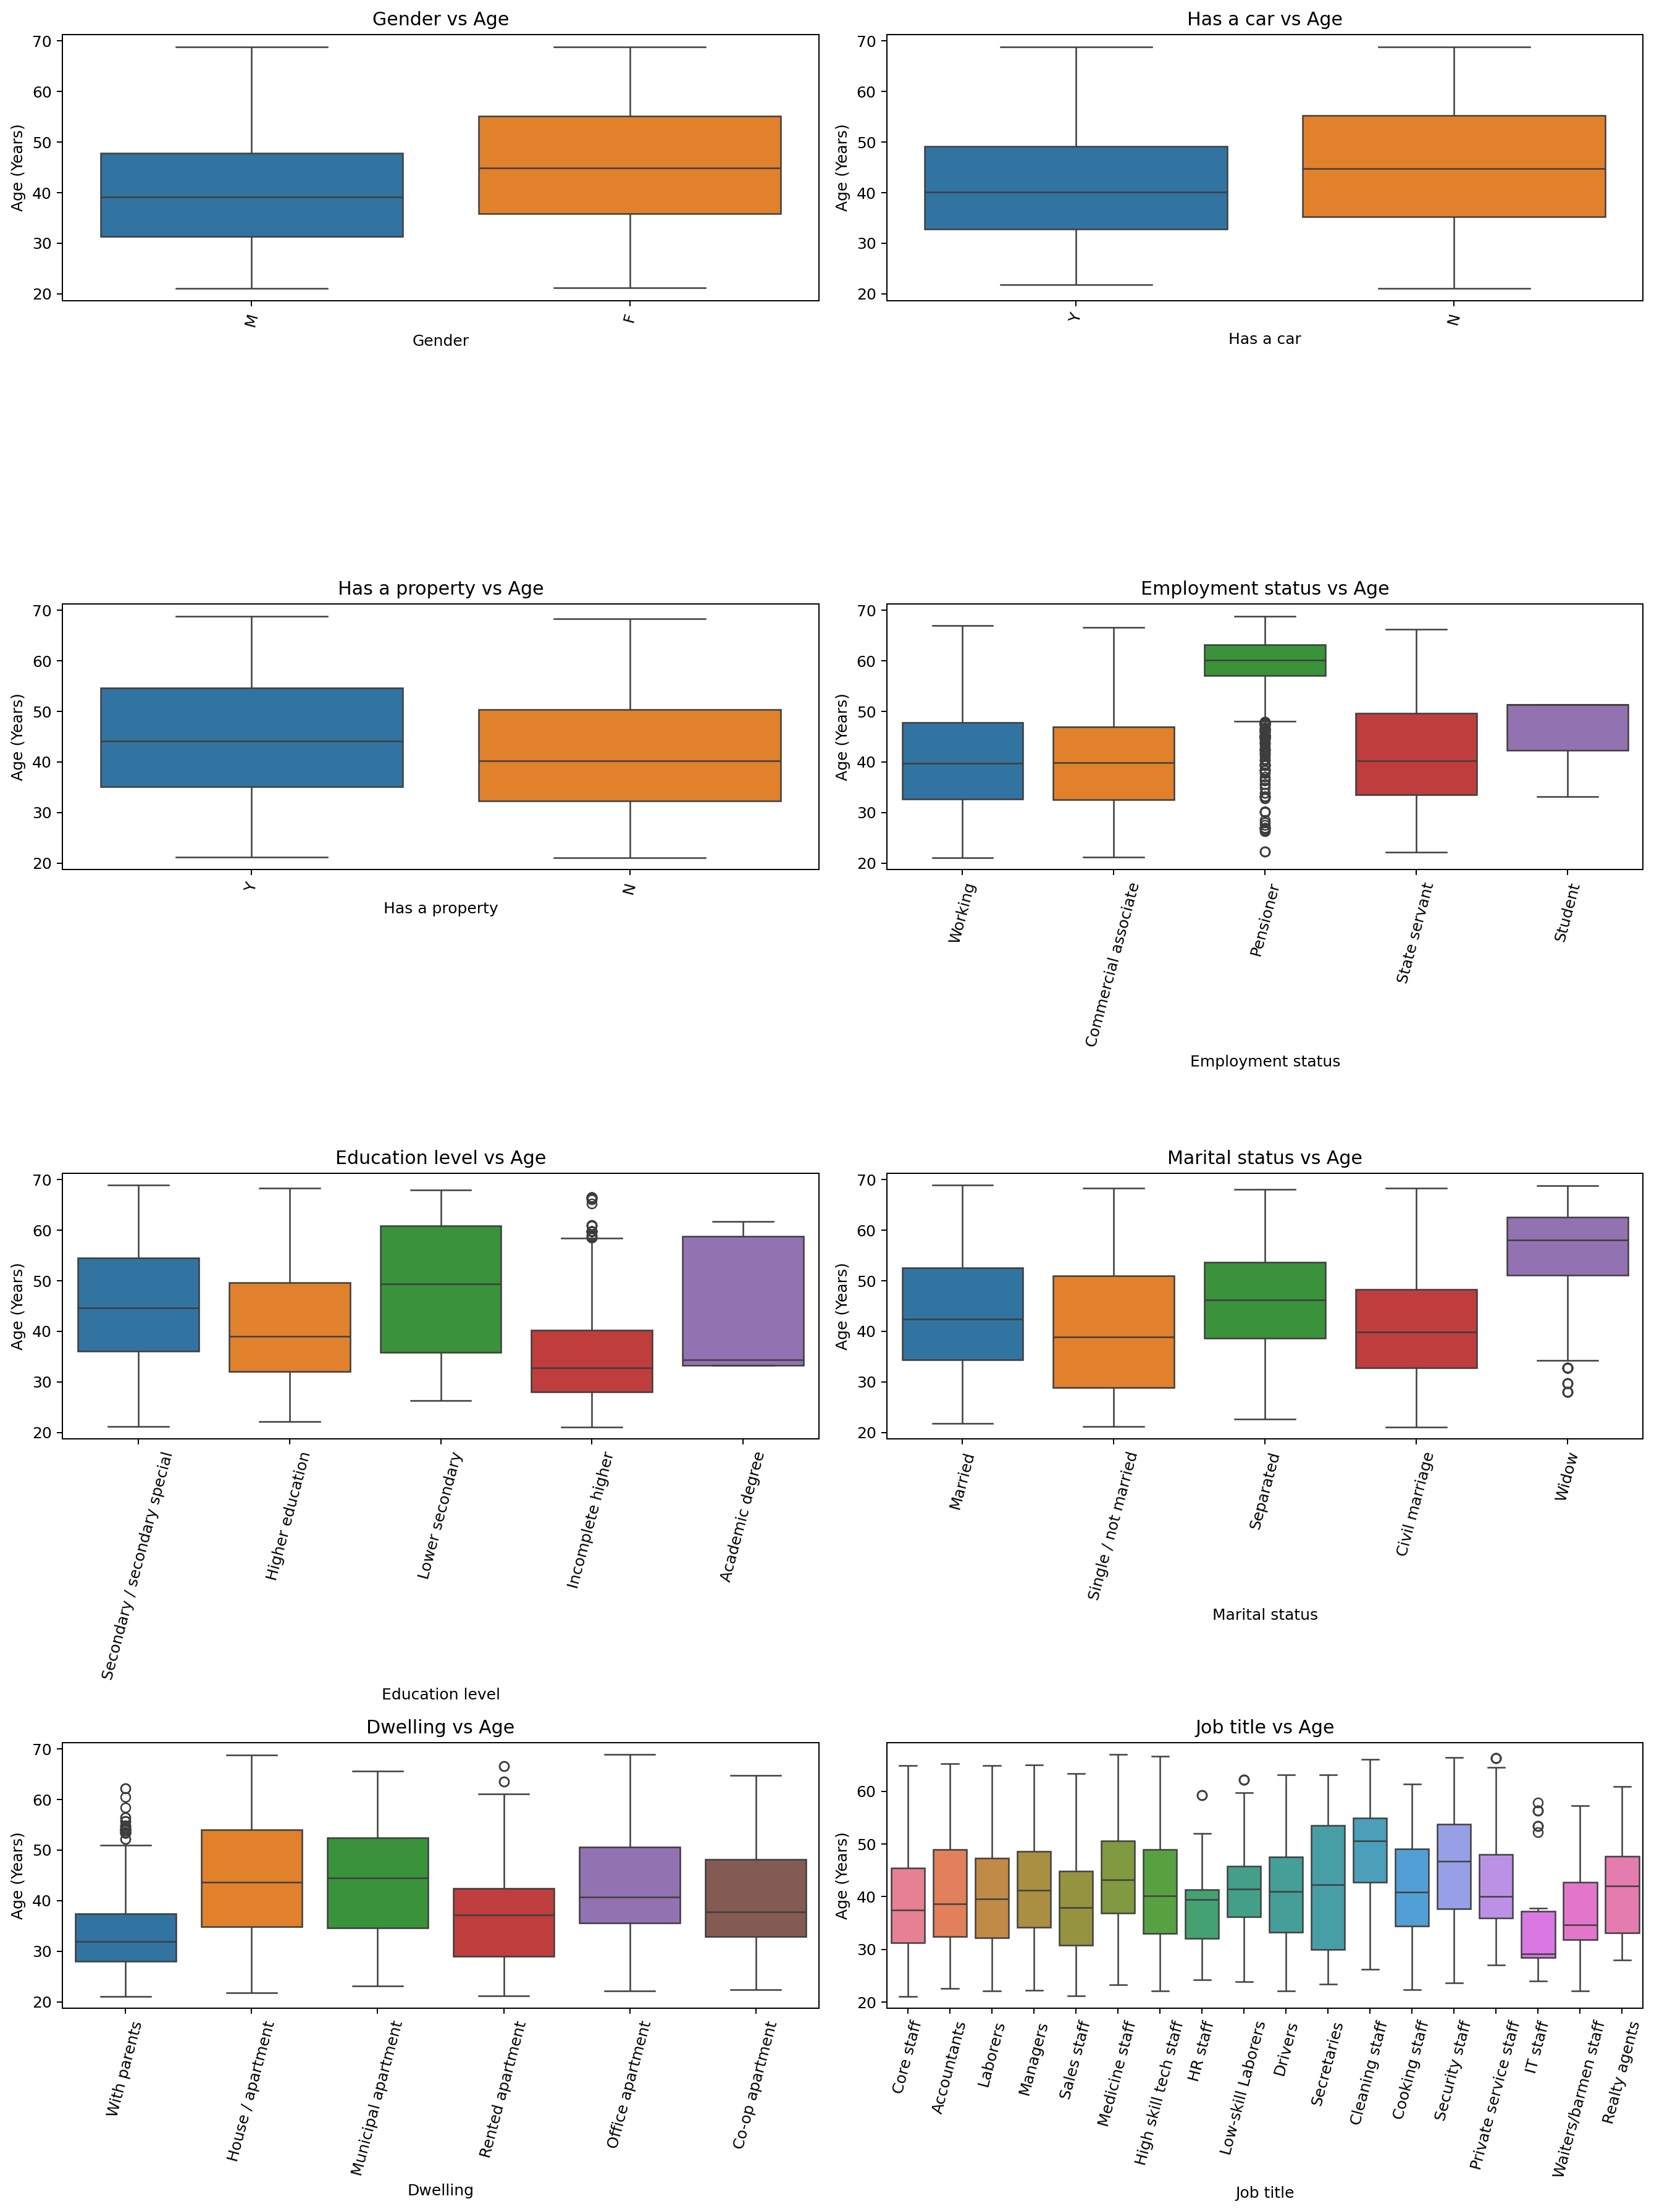

In [998]:
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']

fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig.tight_layout(pad=5.0)

axes = axes.flatten()

for cat_ft_count, feature in enumerate(cat_features):
    sns.boxplot(ax=axes[cat_ft_count], x=train_copy[feature], y=np.abs(train_copy['Age']) / 365.25, hue=train_copy[feature])
    axes[cat_ft_count].set_title(f"{feature} vs Age")
    axes[cat_ft_count].set_ylabel('Age (Years)')
    axes[cat_ft_count].set_xlabel(feature)
    axes[cat_ft_count].tick_params(axis='x', rotation=75)
    
    if axes[cat_ft_count].legend_ is not None:
        axes[cat_ft_count].legend_.remove()

plt.tight_layout()
plt.show()


### Interpretation:

- Female applicants are older than their male counterpart.
- Those who don't own a car tend to be older.
- Those who own a property tend to be older than those who don't.
- Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).
- It is also interesting to see that those who hold an academic degree are younger in general than the other groups.
- Obviously, the widows tend to be much older. We also see some outliers in their 30's as well.
- With no surprise, those who live with parent tend to be younger. We also see some outlier as well.
- Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.

### Income vs the rest of categorical features

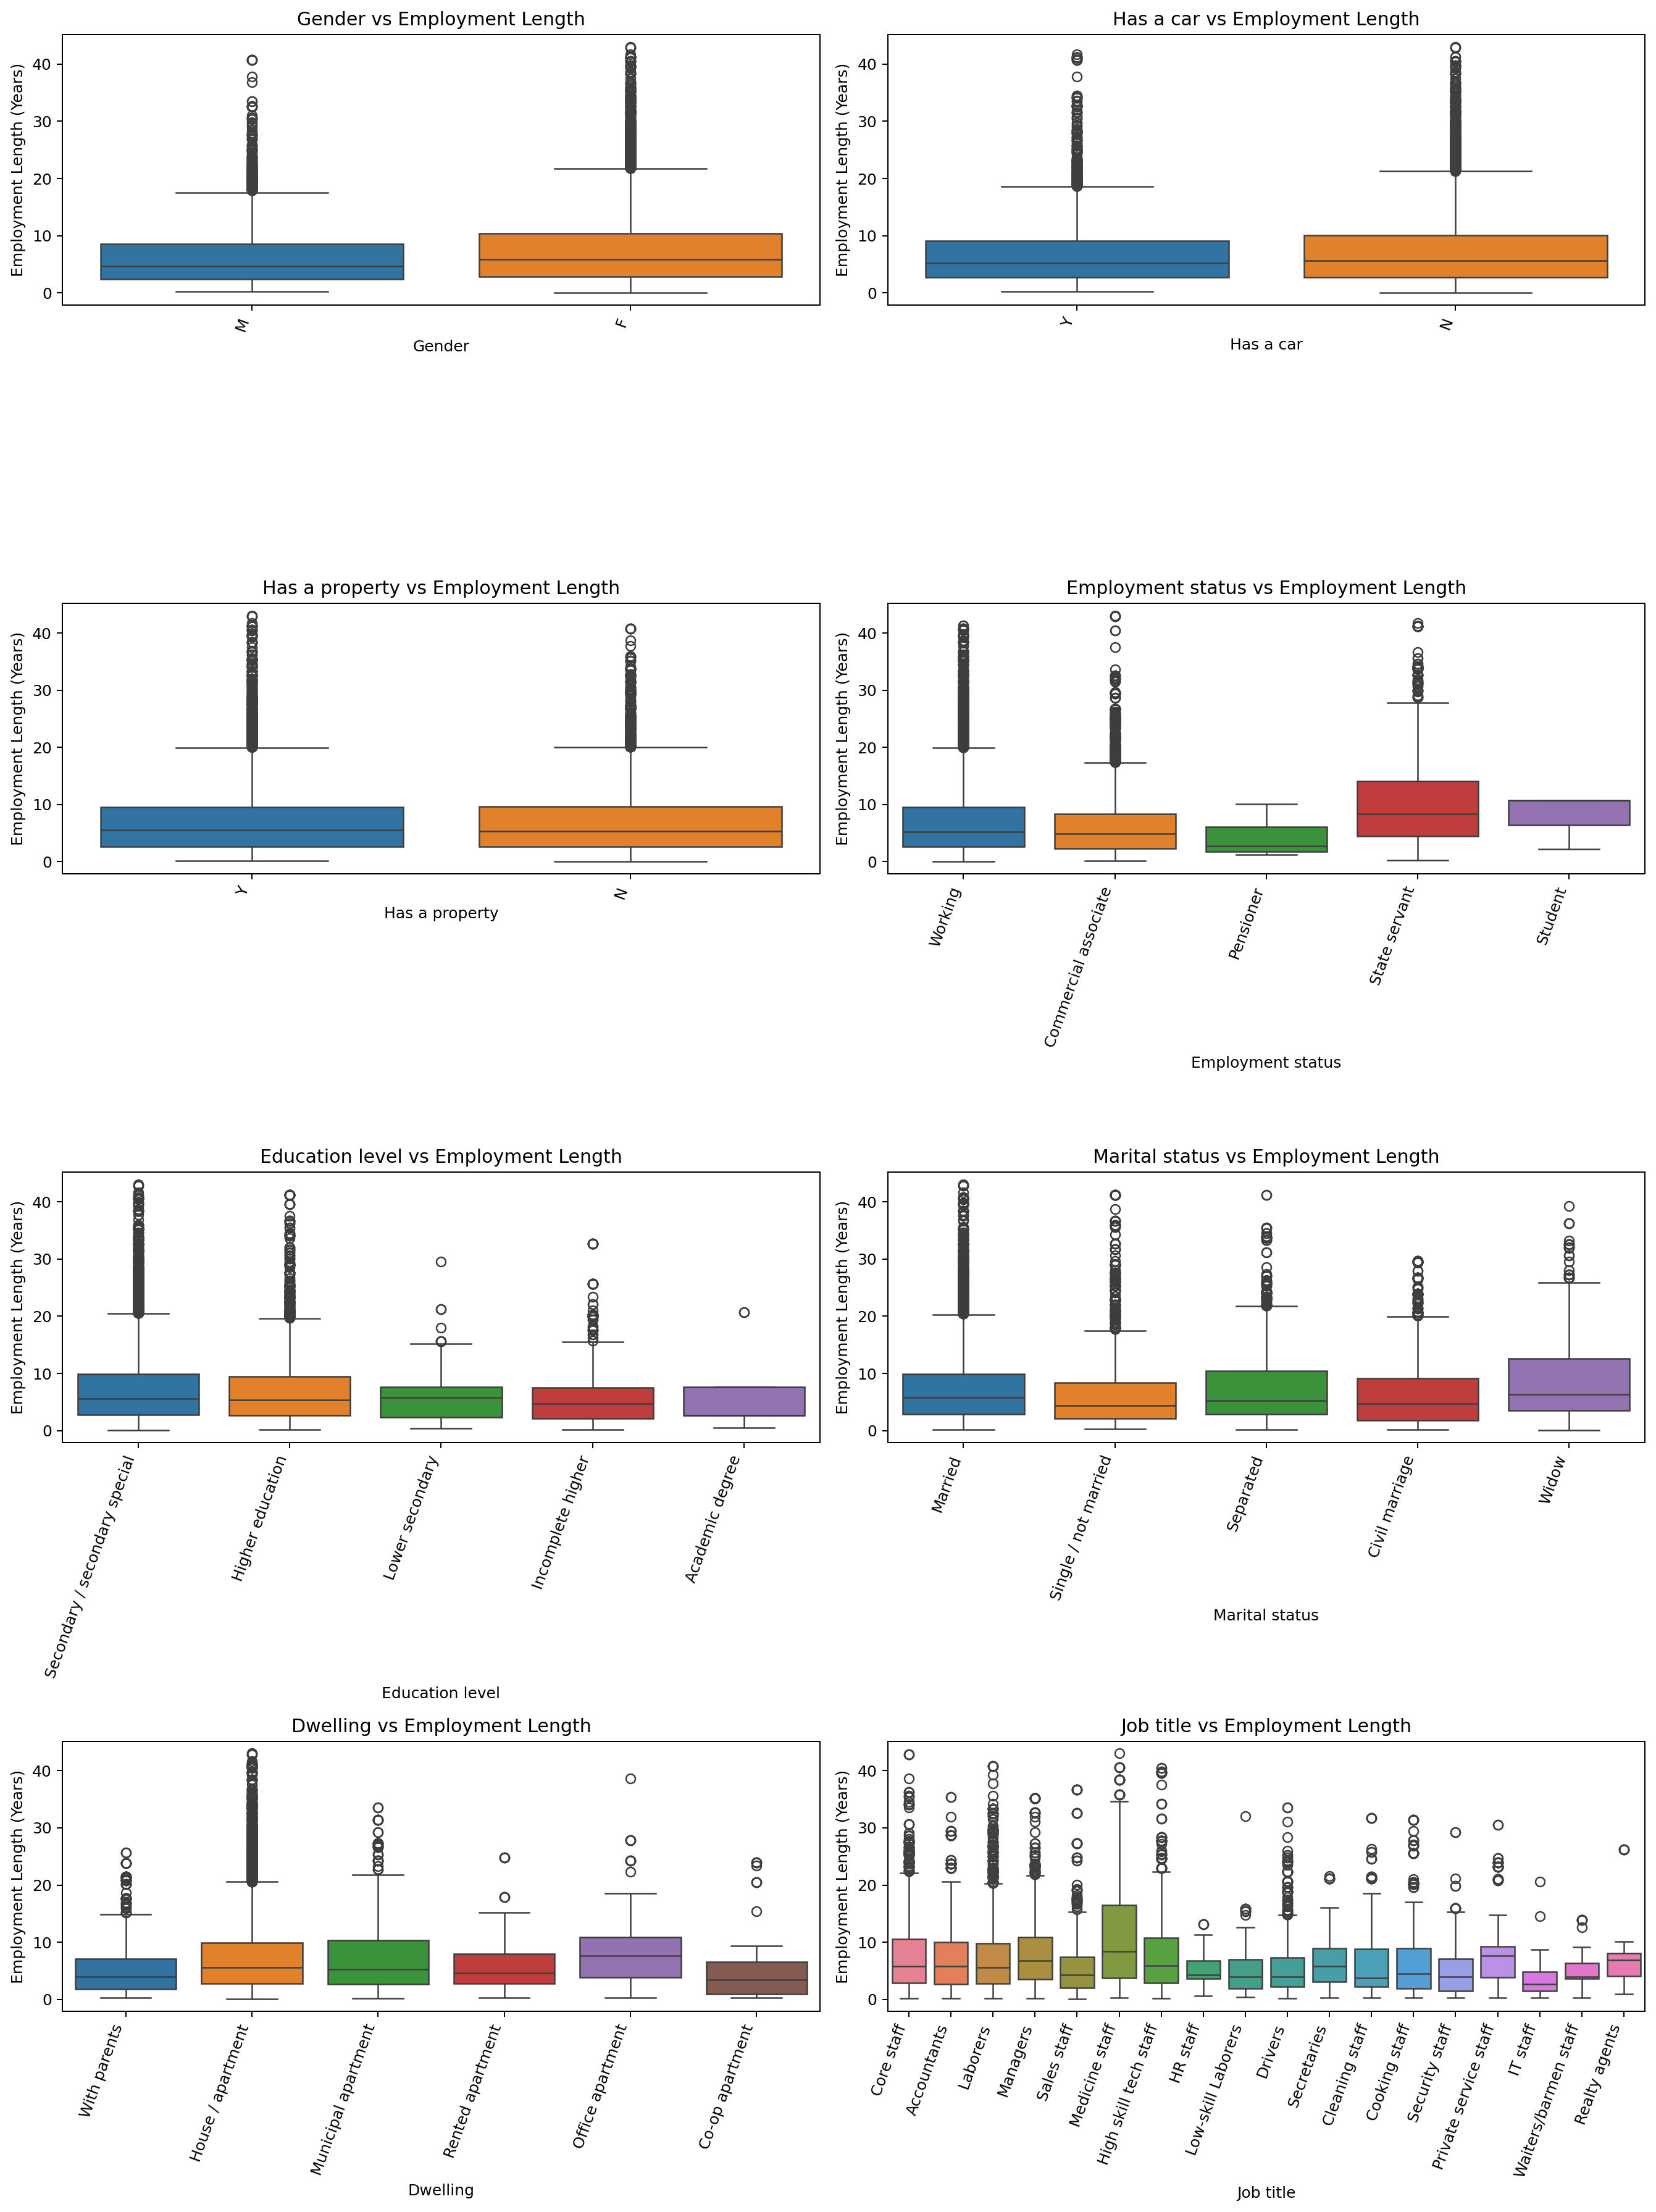

In [1002]:
fig, axes = plt.subplots(4, 2, figsize=(15, 20), dpi=180)
fig.tight_layout(pad=5.0)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the categorical features and plot
for cat_ft_count, feature in enumerate(cat_features):
    sns.boxplot(
        ax=axes[cat_ft_count],
        x=train_copy[feature],
        y=np.abs(train_copy.loc[train_copy['Employment length'] < 0, 'Employment length']) / 365.25,
        hue=train_copy[feature]
    )
    axes[cat_ft_count].set_title(f"{feature} vs Employment Length")
    axes[cat_ft_count].set_ylabel('Employment Length (Years)')
    axes[cat_ft_count].set_xlabel(feature)
    axes[cat_ft_count].set_xticklabels(axes[cat_ft_count].get_xticklabels(), rotation=70, ha='right')

    if axes[cat_ft_count].legend_ is not None:
        axes[cat_ft_count].legend_.remove()

plt.tight_layout()
plt.show()


### Interpretation:

- State employed applicant tend to have been employed longer than the rest.
- Those who work in the medical field, have been employed longer than the rest.

## Categorical vs categorical features (Chi-square test)

Null hypothesis: the feature's categories have no effect on the target variable.

Alternate hypothesis: one(or more) of the feature categories has a significant effect on the target variable.

In [947]:
from scipy.stats import chi2_contingency
import pandas as pd

# Define the chi-square test function
def chi_sq(feature):
    # Generate the contingency table
    contingency_table = pd.crosstab(train_copy[feature], train_copy['Is high risk'])
    # Perform the chi-square test
    stat, p, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results
    print(f"\n**** {feature} ****\n")
    print(f"Chi-Square Statistic: {stat}")
    print(f"p-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Observed Frequencies:\n{contingency_table}")
    print(f"Expected Frequencies:\n{expected}")
    if p < 0.05:
        print(f"Since p vlaue < 0.05 we reject the null hypothesis and conclude {feature} has significant effect on the target variable")
    else:
        print(f"Since p vlaue > 0.05 we fail to reject the null hypothesis and conclude {feature} does not have a significant effect on the target variable")
        

# List of categorical features
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status',
                'Education level', 'Marital status', 'Dwelling', 'Job title']

# Apply the chi-square test for each feature
for feature in cat_features:
    chi_sq(feature)



**** Gender ****

Chi-Square Statistic: 7.2198190810918454
p-value: 0.0072102974472554775
Degrees of Freedom: 1
Observed Frequencies:
Is high risk      0    1
Gender                  
F             19243  306
M              9423  193
Expected Frequencies:
[[19214.52542431   334.47457569]
 [ 9451.47457569   164.52542431]]
Since p vlaue < 0.05 we reject the null hypothesis and conclude Gender has significant effect on the target variable

**** Has a car ****

Chi-Square Statistic: 0.348204727221194
p-value: 0.5551311539343562
Degrees of Freedom: 1
Observed Frequencies:
Is high risk      0    1
Has a car               
N             17811  317
Y             10855  182
Expected Frequencies:
[[17817.83809361   310.16190639]
 [10848.16190639   188.83809361]]
Since p vlaue > 0.05 we fail to reject the null hypothesis and conclude Has a car does not have a significant effect on the target variable

**** Has a property ****

Chi-Square Statistic: 18.78264211208849
p-value: 1.4649435529152808e-

### Business findings from the EDA

- Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child.She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.
- Age and income do not have any effects on the target variable.
- Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.
- Most applicants are 20 to 45 years old and have an account that is 25 months old or less.

In [948]:
train_copy.head(10)

ID Gender Has a car Has a property  Children count    Income  \
0  5037048      M         Y              Y               0 135000.00   
1  5044630      F         Y              N               1 135000.00   
2  5079079      F         N              Y               2 180000.00   
3  5112872      F         Y              Y               0 360000.00   
4  5105858      F         N              N               0 270000.00   
5  5100411      F         Y              Y               0 135000.00   
6  5022817      M         Y              Y               0 202500.00   
7  5009811      F         N              N               1 202500.00   
8  5113922      F         N              N               0  90000.00   
9  5021541      F         Y              N               1 306000.00   

      Employment status                Education level        Marital status  \
0               Working  Secondary / secondary special               Married   
1  Commercial associate               Higher education  Single / not married   
2  Commercial associate  Secondary / secondary special               Married   
3  Commercial associate               Higher education  Single / not married   
4               Working  Secondary / secondary special             Separated   
5               Working  Secondary / secondary special               Married   
6               Working  Secondary / secondary special               Married   
7               Working  Secondary / secondary special               Married   
8             Pensioner  Secondary / secondary special  Single / not married   
9               Working               Higher education               Married   

              Dwelling    Age  Employment length  Has a mobile phone  \
0         With parents -16271              -3111                   1   
1    House / apartment -10130              -1651                   1   
2    House / apartment -12821              -5657                   1   
3    House / apartment -20929              -2046                   1   
4    House / apartment -16207               -515                   1   
5    House / apartment -13251              -3839                   1   
6    House / apartment -17262              -1617                   1   
7    House / apartment -11813              -3266                   1   
8  Municipal apartment -23478             365243                   1   
9    House / apartment  -9310              -1678                   1   

   Has a work phone  Has a phone  Has an email    Job title  \
0                 0            0             0   Core staff   
1                 0            0             0  Accountants   
2                 0            0             0     Laborers   
3                 0            0             1     Managers   
4                 0            1             0          NaN   
5                 1            0             0  Accountants   
6                 0            0             0   Core staff   
7                 1            1             0  Sales staff   
8                 0            0             0          NaN   
9                 0            0             0          NaN   

   Family member count  Account age Is high risk  
0                 2.00       -17.00            0  
1                 2.00        -1.00            0  
2                 4.00       -38.00            0  
3                 1.00       -11.00            0  
4                 1.00       -41.00            0  
5                 2.00        -1.00            0  
6                 2.00       -16.00            0  
7                 3.00       -21.00            0  
8                 1.00       -50.00            0  
9                 3.00       -13.00            0

# Prepare the data

## Transform to be done on each feature

ID:
- Drop the feature

Gender:
- One hot encoding

Age:
- Min-max scaling
- Fix skewness
- Abs value and div 365.25

Marital status:
- One hot encoding

Family member count
- Fix outliers

Children count
- Fix outliers
- Drop feature

Dwelling type
- One hot encoding

Income
- Remove outliers
- Fix skewness
- Min-max scaling

Job title
- One hot encoding
- Impute missing values

Employment status:
- One hot encoding

Education level:
- Ordinal encoding

Employment length:
- Remove outliers
- Min-max scaling
- Abs value and div 365.25
- change days of employments of retirees to 0

Has a car:
- Change it numerical
- One-hot encoding

Has a property:
- Change it numerical
- One-hot encoding

Has a mobile phone:
- Drop feature

Has a work phone:
- One-hot encoding

Has a phone:
- One-hot encoding

Has an email:
- One-hot encoding

Account age:
- Drop feature

Is high risk(Target):
- Change the data type to numerical
- balance the data with SMOTE

### Data Cleaning

#### Outliers handling

In [966]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_outliers = ['Family member count','Income', 'Employment length']):
        self.feat_with_outliers = feat_with_outliers
        
    def fit(self,df):
        return self
    
    def transform(self, df):
        if (set(self.feat_with_outliers).issubset(df.columns)):
            # 25% quantile
            Q1 = df[self.feat_with_outliers].quantile(0.25)
            # 75% quantile
            Q3 = df[self.feat_with_outliers].quantile(0.75)
            
            IQR = Q3 - Q1
            
            df = df[~((df[self.feat_with_outliers]<(Q1 - 3*IQR)) | (df[self.feat_with_outliers]>(Q3 + 3*IQR))).any(axis=1)]
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

### Feature selection

#### Drop features

In [967]:
class DropFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_to_drop = ['ID','Has a mobile phone','Children count','Job title','Account age']):
        self.feature_to_drop = feature_to_drop
    
    def fit(self,df):
        return self
    
    def transform(self, df):
        if (set(self.feature_to_drop).issubset(df.columns)):
            df.drop(self.feature_to_drop, axis=1, inplace = True)
            return df
        else:
            print('One or more features are not in dataframe')
            return df

Why are we droping these features?

- ID: ID is not useful for prediction, it helped us when we were merging the two datasets but after that, there is no need to keep it.

- Has a mobile phone: Since everyone has a mobile phone, this feature does not inform us about anything.

- Children count: is highly correlated with Family member count, and to avoid multicollinearity, we drop it.

- Job title: Has some missing values and the count of each category is not very different to justify the use of mode. So we drop it.

- Account age: Because account was used to create the target, reusing will make our model to overfit. Plus, this information is unknown while applying for a credit card.

### Feature engineering

#### Time conversion

In [968]:
class TimeConversion(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_days = ['Employment length', 'Age']):
        self.feat_with_days = feat_with_days
    
    def fit(self,X, y=None):
        return self
    
    def transform(self, X, y=None):
        if (set(self.feat_with_days).issubset(X.columns)):
            # convert days to absolute value
            X[self.feat_with_days] = np.abs(X[self.feat_with_days])
            return X
        else:
            print('One or more features are not in dataframe')
            return X

#### Retiree handling (in the employment length feature)

In [969]:

class RetireeHandling(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        if 'Employment length' in df.columns:
            # select rows with employment length is 365243 which corresponds to retirees
            df_ret_idx = df['Employment length'][df['Employment length']==365243].index
            # change 365243 to 0
            df.loc[df_ret_idx,'Employment length'] = 0
            return df
        else:
            print('Employment length feature is not in dataframe')
            return df

#### Skewness handeling

In [970]:

class SkewnessHandeling(BaseEstimator, TransformerMixin):
    def __init__(self, feat_with_skewness=['Income','Age']):
        self.feat_with_skewness = feat_with_skewness
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        if (set(self.feat_with_skewness).issubset(df.columns)):
            # Handle skewness with cubic root transformation
            df[self.feat_with_skewness] = np.cbrt(df[self.feat_with_skewness])
            return df
        else:
            print('One or more features are not in dataframe')
            return df

#### Binning

In [971]:

class BinningNumToYN(BaseEstimator, TransformerMixin):
    def __init__(self,feat_with_num_enc=['Has a work phone','Has a phone','Has an email']):
        self.feat_with_num_enc = feat_with_num_enc
        
    def fit(self,df):
        return self
    
    def transform(self,df):
        if (set(self.feat_with_num_enc).issubset(df.columns)):
            # Change 0 to N and 1 to Y for all the features in feat_with_num_enc
            for ft in self.feat_with_num_enc:
                df[ft] = df[ft].map({1:'Y',0:'N'})
            return df
        else:
            print("One or more features are not in the dataframe")
            return df

#### One hot encoding

In [972]:
class OneHotWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_enc_ft = ['Gender', 'Marital status', 'Dwelling', 'Employment status', 'Has a car', 'Has a property', 'Has a work phone', 'Has a phone', 'Has an email']):
        self.one_hot_enc_ft = one_hot_enc_ft
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        if (set(self.one_hot_enc_ft).issubset(df.columns)):
            
            def one_hot_encoding(df, one_hot_enc_ft):
                one_hot_enc = OneHotEncoder()
                one_hot_enc.fit(df[one_hot_enc_ft])
                feat_names_one_hot_enc = one_hot_enc.get_feature_names_out(one_hot_enc_ft)
                df = pd.DataFrame(one_hot_enc.transform(df[self.one_hot_enc_ft]).toarray(), columns=feat_names_one_hot_enc, index=df.index)
                return df
            
            def concat_with_rest(df, one_hot_enc_df, one_hot_enc_ft):
                rest_of_feats = [ft for ft in df.columns if ft not in one_hot_enc_ft]
                df_concat = pd.concat([one_hot_enc_df,df[rest_of_feats]],axis=1)
                return df_concat
            
            one_hot_enc_df = one_hot_encoding(df, self.one_hot_enc_ft)
            full_one_hot_enc_df = concat_with_rest(df, one_hot_enc_df, self.one_hot_enc_ft)
            
            return full_one_hot_enc_df
        else:
            print("One or more features are not in the dataframe")
            return df

#### Ordinal encoding

In [973]:
class OrdinalFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self,ordinal_enc_ft = ['Education level']):
        self.ordinal_enc_ft = ordinal_enc_ft
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        if 'Education level' in df.columns:
            oridinal_enc = OrdinalEncoder()
            df[self.ordinal_enc_ft] = oridinal_enc.fit_transform(df[self.ordinal_enc_ft])
            return df
        else:
            print('Education level is not in the dataframe')
            return df

#### Min-Max scaling

In [974]:


class MinMaxWithFeatNames(BaseEstimator, TransformerMixin):
    def __init__(self, min_max_scaler_ft = ['Age', 'Income', 'Employment length']):
        self.min_max_scaler_ft = min_max_scaler_ft
        
    def fit(self, df):
        return self
    
    def transform(self, df):
        if (set(self.min_max_scaler_ft).issubset(df.columns)):
            min_max_enc = MinMaxScaler()
            df[self.min_max_scaler_ft] = min_max_enc.fit_transform(df[self.min_max_scaler_ft])
            return df
        else:
            print('One or more features are not in the dataframe')
            return df

#### Change the data types of the target feature

In [975]:
class ChangeToNumTarget(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        if 'Is high risk' in df.columns:
            df['Is high risk'] = pd.to_numeric(df['Is high risk'])
            return df
        else:
            print('Is high risk is not in the dataframe')
            return df

#### Oversampling

In [976]:
class Oversample(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, df):
        return self
    
    def transform(self, df):
        if 'Is high risk' in df.columns:
            oversample = SMOTE(sampling_strategy='minority')
            X_bal, y_bal = oversample.fit_resample(df.loc[:,df.columns != 'Is high risk'], df['Is high risk'])
            df_bal = pd.concat([pd.DataFrame(X_bal), pd.DataFrame(y_bal)], axis=1)
            return df_bal
        else:
            print('Is high risk is not in the dataframe')
            return df

## Data Preprocessing

In [977]:
from sklearn.pipeline import Pipeline


def full_pipeline(df):
    pipeline = Pipeline([
        ('OutlierRemover', OutlierRemover()),
        ('DropFeatures', DropFeatures()),
        ('TimeConversion', TimeConversion()),
        ('RetireeHandling', RetireeHandling()),
        ('SkewnessHandeling', SkewnessHandeling()),
        ('BinningNumToYN', BinningNumToYN()),
        ('OneHotWithFeatNames', OneHotWithFeatNames()),
        ('OrdinalFeatNames', OrdinalFeatNames()),
        ('MinMaxWithFeatNames', MinMaxWithFeatNames()),
        ('ChangeToNumTarget', ChangeToNumTarget()),
        ('Oversample', Oversample())
    ])
    df_pipe_prep = pipeline.fit_transform(df)
    return df_pipe_prep

In [981]:
train_copy_preprocessed = full_pipeline(train_copy)
train_copy_preprocessed.head(10)

Gender_F  Gender_M  Marital status_Civil marriage  Marital status_Married  \
0      0.00      1.00                           0.00                    1.00   
1      1.00      0.00                           0.00                    0.00   
2      1.00      0.00                           0.00                    1.00   
3      1.00      0.00                           0.00                    0.00   
4      1.00      0.00                           0.00                    0.00   
5      1.00      0.00                           0.00                    1.00   
6      0.00      1.00                           0.00                    1.00   
7      1.00      0.00                           0.00                    1.00   
8      1.00      0.00                           0.00                    1.00   
9      0.00      1.00                           0.00                    1.00   

   Marital status_Separated  Marital status_Single / not married  \
0                      0.00                                 0.00   
1                      0.00                                 1.00   
2                      0.00                                 0.00   
3                      0.00                                 1.00   
4                      1.00                                 0.00   
5                      0.00                                 0.00   
6                      0.00                                 0.00   
7                      0.00                                 0.00   
8                      0.00                                 0.00   
9                      0.00                                 0.00   

   Marital status_Widow  Dwelling_Co-op apartment  Dwelling_House / apartment  \
0                  0.00                      0.00                        0.00   
1                  0.00                      0.00                        1.00   
2                  0.00                      0.00                        1.00   
3                  0.00                      0.00                        1.00   
4                  0.00                      0.00                        1.00   
5                  0.00                      0.00                        1.00   
6                  0.00                      0.00                        1.00   
7                  0.00                      0.00                        1.00   
8                  0.00                      0.00                        1.00   
9                  0.00                      0.00                        1.00   

   Dwelling_Municipal apartment  ...  Has a phone_N  Has a phone_Y  \
0                          0.00  ...           1.00           0.00   
1                          0.00  ...           1.00           0.00   
2                          0.00  ...           1.00           0.00   
3                          0.00  ...           1.00           0.00   
4                          0.00  ...           0.00           1.00   
5                          0.00  ...           1.00           0.00   
6                          0.00  ...           1.00           0.00   
7                          0.00  ...           0.00           1.00   
8                          0.00  ...           1.00           0.00   
9                          0.00  ...           1.00           0.00   

   Has an email_N  Has an email_Y  Income  Education level  Age  \
0            1.00            0.00    0.42             4.00 0.60   
1            1.00            0.00    0.42             1.00 0.20   
2            1.00            0.00    0.52             4.00 0.39   
3            0.00            1.00    0.81             1.00 0.84   
4            1.00            0.00    0.68             4.00 0.60   
5            1.00            0.00    0.42             4.00 0.42   
6            1.00            0.00    0.56             4.00 0.66   
7            1.00            0.00    0.56             4.00 0.33   
8            1.00            0.00    0.73             1.00 0.14   
9            1.00            0.00    0.7

In [982]:
X_train_copy_preprocessed,y_train_copy_preprocessed = train_copy_preprocessed.loc[:,train_copy_preprocessed.columns != 'Is high risk'], train_copy_preprocessed['Is high risk'].astype('int64')